In [111]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch
from scipy.stats import f_oneway
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output

Combine the csv file of all Clustered color profile and video metrics using the Video ID 

In [112]:
# Combine all Cluster data and color profile percentage into one DataFrame
color_profile_data = pd.read_csv('Final_Clustering/K=9/Cluster_Color_Profile_Final.csv')

# Load video engagement data
video_data = pd.read_csv('Final_Clustering/Results_Count_Final.csv')

Get rid of the '.jpg' in the video ID in Clustered Color Profile

In [113]:
# Remove the .jpg extension from the VideoID in color_profile_data
color_profile_data['VideoID'] = color_profile_data['VideoID'].str.replace('.jpg', '')

# Check again after cleaning
print("\nCleaned Sample IDs from color_profile_data:")
print(color_profile_data['VideoID'].head())


Cleaned Sample IDs from color_profile_data:
0    --8n6A8Q6M0
1    -0FfyNZdHk0
2    -1B7cVoZr1c
3    -4yu_13EHFM
4    -6FvAU9H98w
Name: VideoID, dtype: object


In [114]:
# Display the first few rows of both datasets
print("\nClustered Color Profile Data:")
print(color_profile_data.head())
print("\nNumber of rows and columns in text_data:", color_profile_data.shape)

print("\nVideo Engagement Data:")
print(video_data.head())
print("\nNumber of rows and columns in video_data:", video_data.shape)


Clustered Color Profile Data:
       VideoID  Yellow  Orange  Red  Violet  Blue  Green  Black  White  Brown  \
0  --8n6A8Q6M0    0.00    0.71  0.0   23.29  0.06   0.00  13.58  13.01  49.35   
1  -0FfyNZdHk0    0.01    0.97  0.0   11.65  0.00   8.13  26.25  13.26  39.73   
2  -1B7cVoZr1c    0.84    0.61  0.0   16.56  7.08   0.00  14.65  32.05  28.21   
3  -4yu_13EHFM    0.00    8.72  0.0   25.99  0.00   0.00  14.83  10.53  39.93   
4  -6FvAU9H98w    0.11   10.24  0.7    6.79  0.04   0.00  12.74  39.01  30.37   

   Cluster  
0        1  
1        5  
2        2  
3        1  
4        2  

Number of rows and columns in text_data: (2587, 11)

Video Engagement Data:
       VideoID  View Count  Like Count  Comment Count
0  --8n6A8Q6M0      338385       11044           1371
1  -0FfyNZdHk0         147           4              1
2  -1B7cVoZr1c      150876        3011            225
3  -4yu_13EHFM       28277        1158            381
4  -6FvAU9H98w       63409        1277            110

Nu

In [115]:
# Merge datasets on 'Video ID'
merged_data = pd.merge(color_profile_data, video_data, on='VideoID', how='inner')

# Read the results_final.csv file
results_df = pd.read_csv('results_final.csv')

# Rename the 'Video Id' column to 'VideoID' in results_df to match merged_data
results_df = results_df.rename(columns={'Video Id': 'VideoID'})

# Merge the Channel Title from results_df into merged_data
merged_data = pd.merge(merged_data, results_df[['VideoID', 'Channel Title']], on='VideoID', how='inner')


# Check the merged dataset
print("\nMerged Dataset:")
print(merged_data.head())

# Display the number of rows and columns
print("\nNumber of rows and columns:", merged_data.shape)


Merged Dataset:
       VideoID  Yellow  Orange  Red  Violet  Blue  Green  Black  White  Brown  \
0  --8n6A8Q6M0    0.00    0.71  0.0   23.29  0.06   0.00  13.58  13.01  49.35   
1  -0FfyNZdHk0    0.01    0.97  0.0   11.65  0.00   8.13  26.25  13.26  39.73   
2  -1B7cVoZr1c    0.84    0.61  0.0   16.56  7.08   0.00  14.65  32.05  28.21   
3  -4yu_13EHFM    0.00    8.72  0.0   25.99  0.00   0.00  14.83  10.53  39.93   
4  -6FvAU9H98w    0.11   10.24  0.7    6.79  0.04   0.00  12.74  39.01  30.37   

   Cluster  View Count  Like Count  Comment Count            Channel Title  
0        1      338385       11044           1371  Travel with Luke Damant  
1        5         147           4              1        Learn with Daryll  
2        2      150876        3011            225      Combat Arms Channel  
3        1       28277        1158            381         Chasing Kimberly  
4        2       63409        1277            110          Paolo fromTOKYO  

Number of rows and columns: (2568

Check the number of channels per cluster, to see the difference on each channel

In [116]:
# Group by Cluster and Channel Title, then count videos
cluster_channel_counts = merged_data.groupby(['Cluster', 'Channel Title']).size().reset_index(name='Video Count')

# Sort by Cluster and Video Count in descending order
cluster_channel_counts = cluster_channel_counts.sort_values(['Cluster', 'Video Count'], ascending=[True, False])

# Create a list to store the top 10 channels per cluster
top_channels = []

# Get top 10 channels for each cluster
for cluster in sorted(cluster_channel_counts['Cluster'].unique()):
    # Get top 10 channels for this cluster
    cluster_data = cluster_channel_counts[cluster_channel_counts['Cluster'] == cluster].nlargest(10, 'Video Count')
    
    # Add cluster header
    top_channels.append({
        'Cluster': f"Cluster {cluster}",
        'Channel': '---',
        'Video Count': '---'
    })
    
    # Add top 10 channels
    for _, row in cluster_data.iterrows():
        top_channels.append({
            'Cluster': '',
            'Channel': row['Channel Title'],
            'Video Count': row['Video Count']
        })

# Create DataFrame from formatted results
result_df = pd.DataFrame(top_channels)

# Save to CSV
result_df.to_csv('Final_clustering/K=9/Correlational/top_channels_per_cluster.csv', index=False)

# Print the results
print("\nTop 10 channels per cluster:")
for cluster in sorted(cluster_channel_counts['Cluster'].unique()):
    cluster_data = cluster_channel_counts[cluster_channel_counts['Cluster'] == cluster].nlargest(10, 'Video Count')
    print(f"\nCluster {cluster}:")
    for _, row in cluster_data.iterrows():
        print(f"Channel: {row['Channel Title']} - Videos: {row['Video Count']}")


Top 10 channels per cluster:

Cluster 0:
Channel: Music Game News - Videos: 24
Channel: Nic & Rei - Videos: 18
Channel: Pinoy Planet - Videos: 12
Channel: Adam and Jane's Lifestyle - Videos: 6
Channel: KIM n LEE - Videos: 6
Channel: Waleska Herrera - Videos: 6
Channel: Beryl Shereshewsky - Videos: 5
Channel: FoodieMommaPH - Videos: 5
Channel: People Vs Food - Videos: 5
Channel: Big Guy Appetite - Videos: 4

Cluster 1:
Channel: Waleska Herrera - Videos: 70
Channel: Adam and Jane's Lifestyle - Videos: 32
Channel: The Commodity - Videos: 22
Channel: Pinoy Planet - Videos: 17
Channel: The Demouchets REACT - Videos: 16
Channel: TPL Bianca - Videos: 15
Channel: Justin & Alina - Videos: 13
Channel: Ken Abroad - Videos: 13
Channel: Aaron Around - Videos: 10
Channel: VI3ION - Videos: 10

Cluster 2:
Channel: Japapino World ジャパピーノ - Videos: 10
Channel: Pinoy Planet - Videos: 8
Channel: JUICY REACTS - Videos: 7
Channel: Nic & Rei - Videos: 7
Channel: Paolo fromTOKYO - Videos: 7
Channel: Waleska H

line graph of vid per channel in every cluster

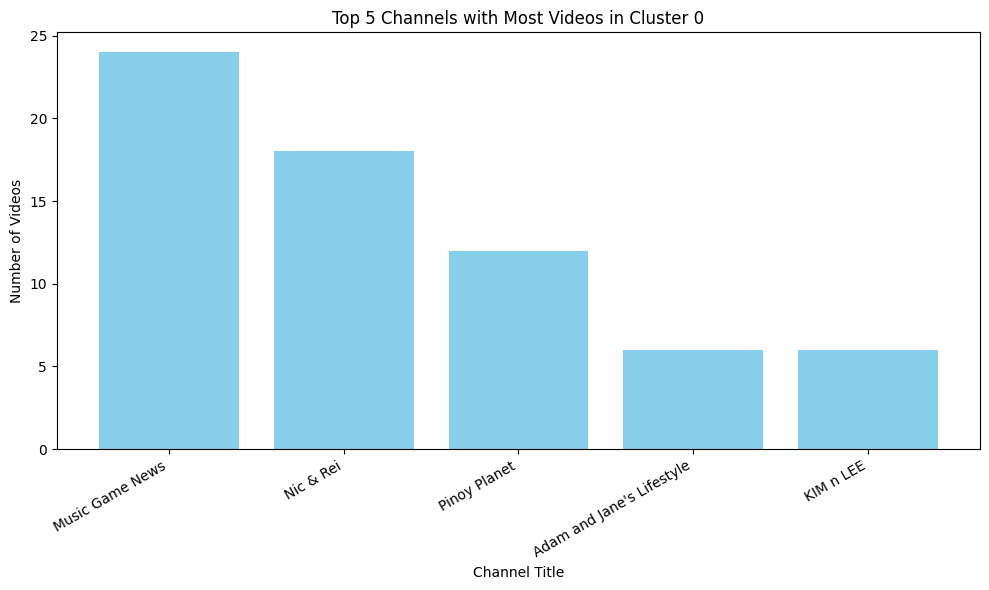

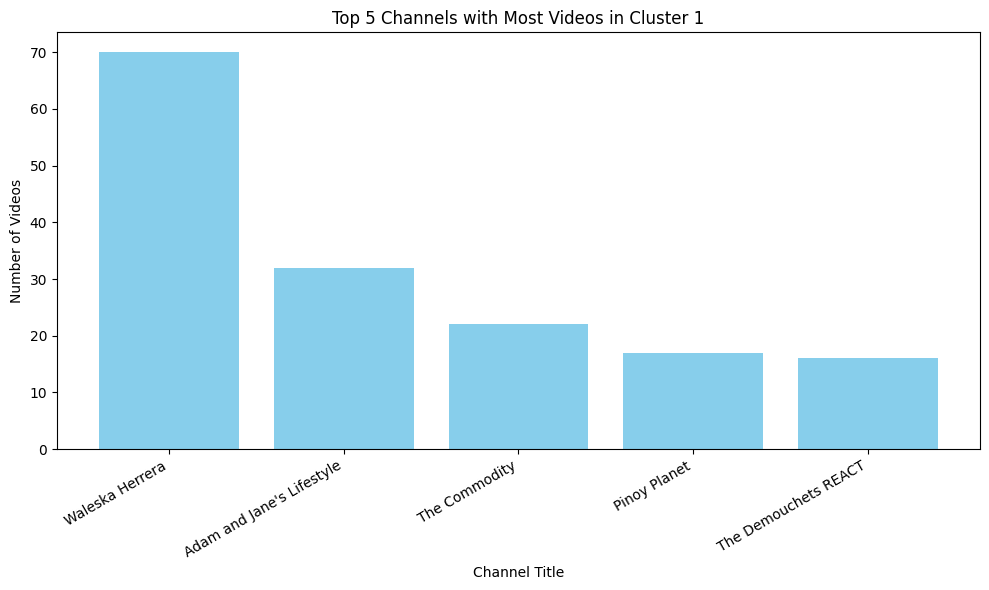

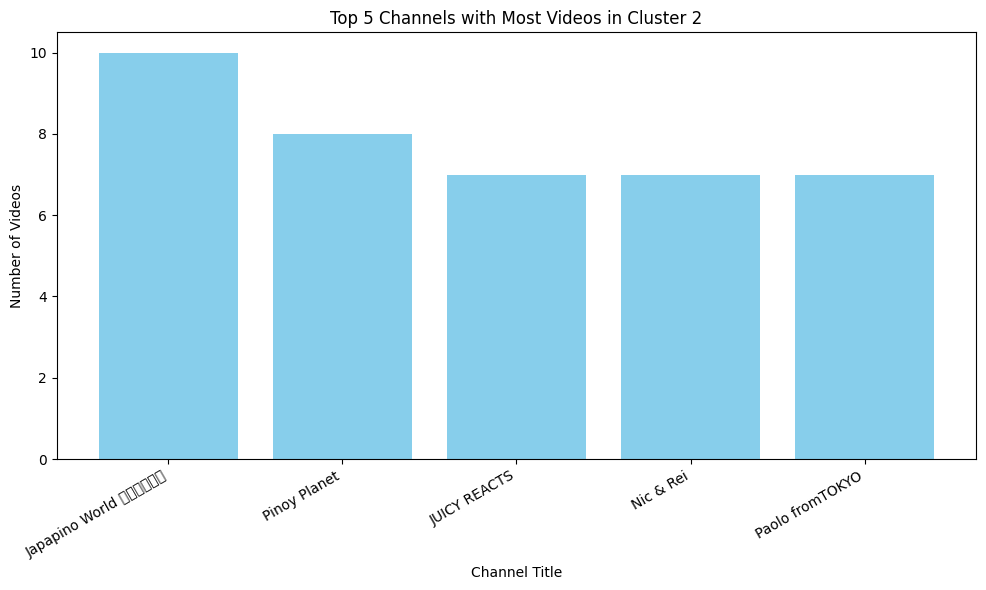

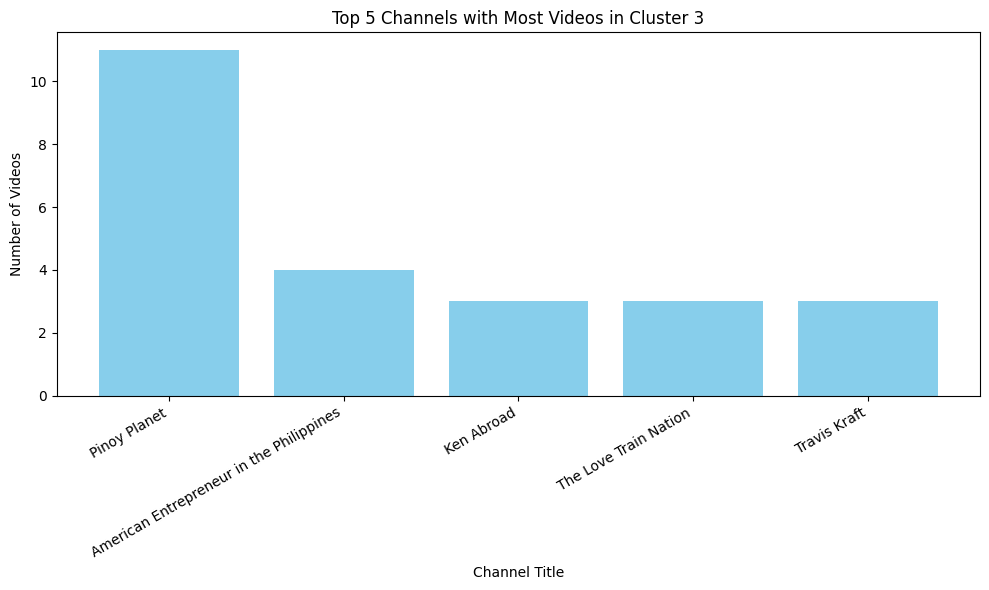

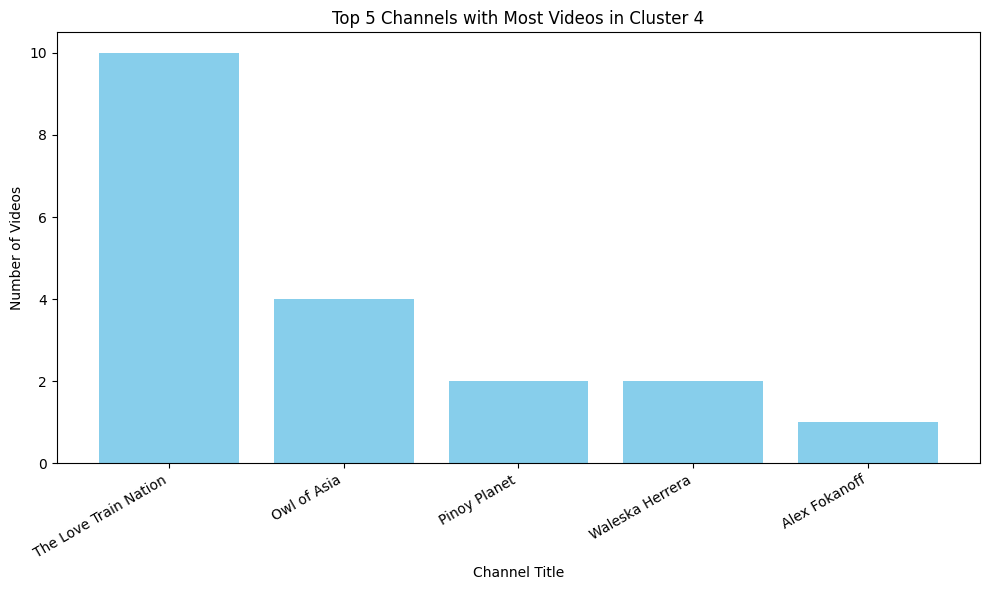

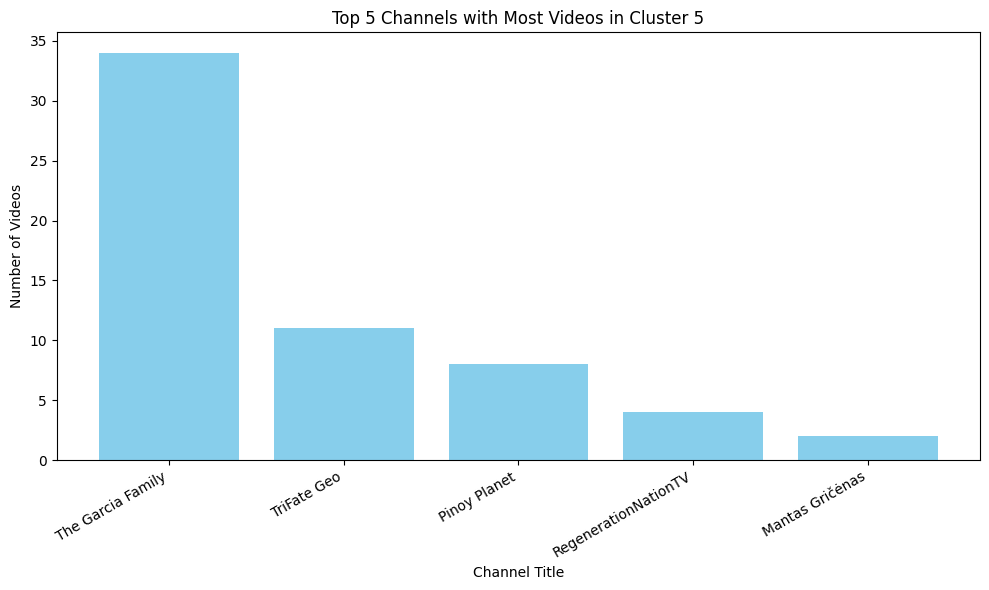

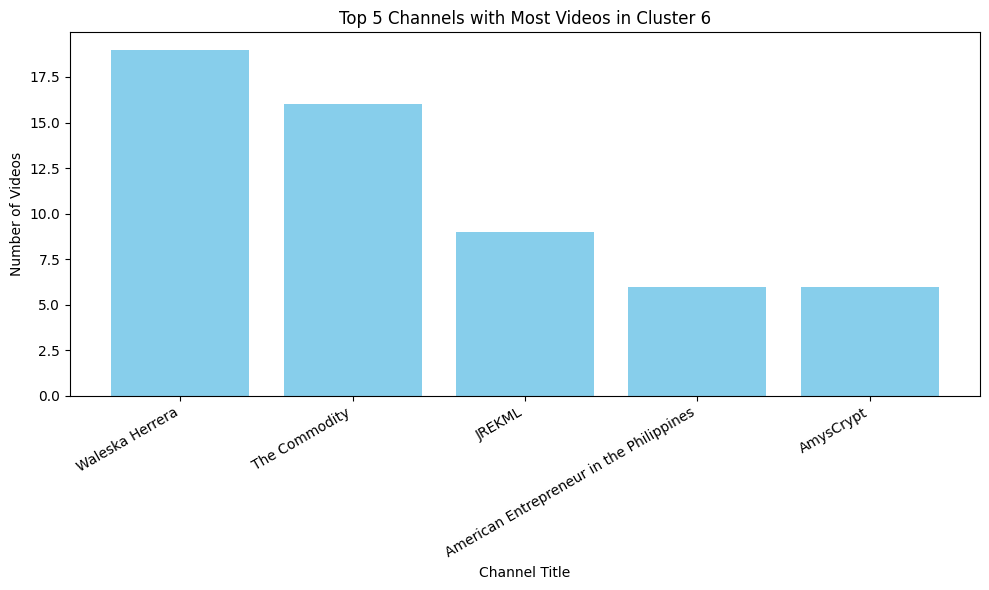

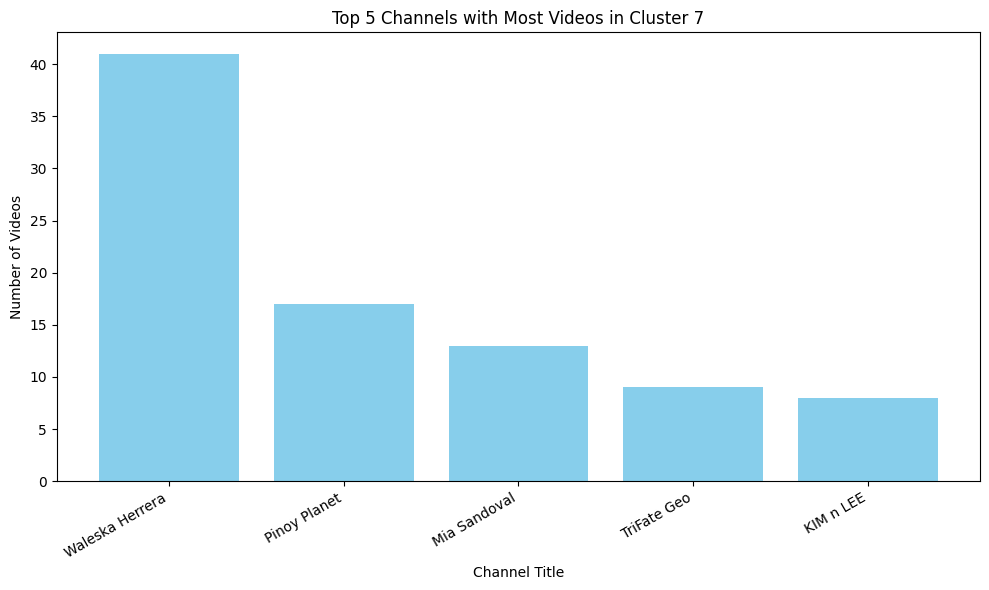

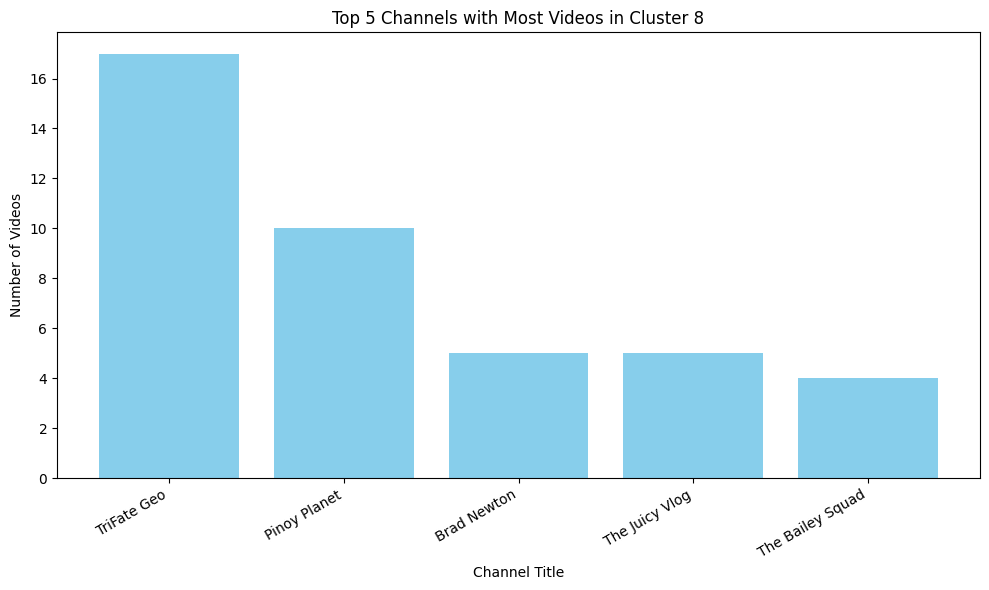

In [117]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Cluster and Channel Title, then count videos
cluster_channel_counts = merged_data.groupby(['Cluster', 'Channel Title']).size().reset_index(name='Video Count')

# Sort by Cluster and Video Count in descending order
cluster_channel_counts = cluster_channel_counts.sort_values(['Cluster', 'Video Count'], ascending=[True, False])

# Plotting
clusters = sorted(cluster_channel_counts['Cluster'].unique())
for cluster in clusters:
    cluster_data = cluster_channel_counts[cluster_channel_counts['Cluster'] == cluster]
    # Get top 5 channels for this cluster
    top5 = cluster_data.nlargest(5, 'Video Count')[['Channel Title', 'Video Count']]
    
    plt.figure(figsize=(10, 6))
    plt.bar(top5['Channel Title'], top5['Video Count'], color='skyblue')
    plt.title(f'Top 5 Channels with Most Videos in Cluster {cluster}')
    plt.xlabel('Channel Title')
    plt.ylabel('Number of Videos')
    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    plt.show()

Get the Channel weight of each

In [118]:
# Calculate channel frequencies across the entire dataset
channel_frequencies = merged_data.groupby('Channel Title').size()
total_videos = len(merged_data)

# Calculate weights (inverse of frequency)
# Add 1 to avoid division by zero and smooth the weights
channel_weights = 1 / (channel_frequencies + 1)

# Normalize weights to sum to 1
channel_weights = channel_weights / channel_weights.sum()

# Create a copy of the original data
weighted_data = merged_data.copy()

# Add weights to the dataset
weighted_data['Channel_Weight'] = weighted_data['Channel Title'].map(channel_weights)

# Print some statistics about the weights
print("\nChannel Weight Statistics:")
print("------------------------")
print(f"Number of unique channels: {len(channel_weights)}")
print(f"Minimum weight: {channel_weights.min():.6f}")
print(f"Maximum weight: {channel_weights.max():.6f}")
print(f"Mean weight: {channel_weights.mean():.6f}")

# Show example of weights for some channels
print("\nExample Channel Weights:")
print("----------------------")
example_channels = channel_weights.nlargest(5).index.tolist() + channel_weights.nsmallest(5).index.tolist()
for channel in example_channels:
    print(f"{channel}:")
    print(f"  Frequency: {channel_frequencies[channel]} videos")
    print(f"  Weight: {channel_weights[channel]:.6f}")

# Calculate weighted statistics for numeric columns
numeric_columns = weighted_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in ['Cluster', 'Channel_Weight']]

# Calculate weighted means for each cluster
weighted_cluster_stats = []
for cluster in sorted(weighted_data['Cluster'].unique()):
    cluster_data = weighted_data[weighted_data['Cluster'] == cluster]
    
    # Calculate weighted statistics
    weighted_stats = {
        'Cluster': cluster,
        'Total_Videos': len(cluster_data),
        'Unique_Channels': len(cluster_data['Channel Title'].unique())
    }
    
    # Calculate weighted means for each numeric column
    for column in numeric_columns:
        weighted_mean = np.average(cluster_data[column], weights=cluster_data['Channel_Weight'])
        weighted_stats[f'Weighted_Mean_{column}'] = weighted_mean
    
    weighted_cluster_stats.append(weighted_stats)

# Convert to DataFrame
weighted_stats_df = pd.DataFrame(weighted_cluster_stats)

# Save the weighted dataset and statistics
weighted_data.to_csv('Final_clustering/K=9/Correlational/channel_weighted_data.csv', index=False)
weighted_stats_df.to_csv('Final_clustering/K=9/Correlational/weighted_cluster_statistics.csv', index=False)

# Print weighted cluster statistics
print("\nWeighted Cluster Statistics:")
print("--------------------------")
print(weighted_stats_df)

# Optional: Create a visualization of the weights distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(channel_weights, bins=50)
plt.title('Distribution of Channel Weights')
plt.xlabel('Weight')
plt.ylabel('Number of Channels')
plt.savefig('Final_clustering/K=9/Correlational/channel_weights_distribution.png')
plt.close()

# Print summary of the weighted analysis
print("\nSummary of Weighted Analysis:")
print("---------------------------")
print(f"Total videos analyzed: {len(weighted_data)}")
print(f"Total unique channels: {len(channel_weights)}")
print(f"Average videos per channel: {channel_frequencies.mean():.2f}")
print(f"Median videos per channel: {channel_frequencies.median():.2f}")
print(f"Maximum videos per channel: {channel_frequencies.max()}")
print(f"Minimum videos per channel: {channel_frequencies.min()}")


Channel Weight Statistics:
------------------------
Number of unique channels: 694
Minimum weight: 0.000028
Maximum weight: 0.002090
Mean weight: 0.001441

Example Channel Weights:
----------------------
10 Tampa Bay:
  Frequency: 1 videos
  Weight: 0.002090
1000 Nomads:
  Frequency: 1 videos
  Weight: 0.002090
1001 Trips - #1001Trips:
  Frequency: 1 videos
  Weight: 0.002090
A Brit in the Philippines:
  Frequency: 1 videos
  Weight: 0.002090
A Kids Perspective:
  Frequency: 1 videos
  Weight: 0.002090
Waleska Herrera:
  Frequency: 151 videos
  Weight: 0.000028
Pinoy Planet:
  Frequency: 89 videos
  Weight: 0.000046
The Commodity:
  Frequency: 51 videos
  Weight: 0.000080
TriFate Geo:
  Frequency: 50 videos
  Weight: 0.000082
Adam and Jane's Lifestyle:
  Frequency: 47 videos
  Weight: 0.000087

Weighted Cluster Statistics:
--------------------------
   Cluster  Total_Videos  Unique_Channels  Weighted_Mean_Yellow  \
0        0           261              131              1.261131   
1  

## ANOVA

Collect Metric Data by Cluster

In [119]:
# Define which video metric columns to analyze
metric_columns_for_anova = ['View Count', 'Like Count', 'Comment Count']
print(f"Metrics selected for analysis: {', '.join(metric_columns_for_anova)}")

Metrics selected for analysis: View Count, Like Count, Comment Count


In [120]:
# Create a dictionary to store ANOVA results
anova_results = {}

# Display information about Clusters
Cluster_sizes = weighted_data['Cluster'].value_counts().sort_index()
Cluster_channel_counts = weighted_data.groupby('Cluster')['Channel Title'].nunique()

print("## Weighted Color Cluster Summary ##")
print(f"Total videos: {len(weighted_data)}")
print(f"Number of Clusters: {len(Cluster_sizes)}")
print(f"Total unique channels: {weighted_data['Channel Title'].nunique()}")
print("\nVideos and Channels per Cluster:")
for Cluster in sorted(Cluster_sizes.index):
    cluster_data = weighted_data[weighted_data['Cluster'] == Cluster]
    weighted_avg = np.average(cluster_data['View Count'], weights=cluster_data['Channel_Weight'])
    print(f"  Cluster {Cluster}:")
    print(f"    Videos: {Cluster_sizes[Cluster]}")
    print(f"    Unique Channels: {Cluster_channel_counts[Cluster]}")
    print(f"    Weighted Average Views: {weighted_avg:,.0f}")
    print(f"    Average Channel Weight: {cluster_data['Channel_Weight'].mean():.4f}")

# Save cluster summary to CSV
cluster_summary = pd.DataFrame({
    'Cluster': Cluster_sizes.index,
    'Total_Videos': Cluster_sizes.values,
    'Unique_Channels': Cluster_channel_counts.values,
    'Weighted_Avg_Views': [np.average(weighted_data[weighted_data['Cluster'] == c]['View Count'], 
                                    weights=weighted_data[weighted_data['Cluster'] == c]['Channel_Weight']) 
                          for c in Cluster_sizes.index],
    'Avg_Channel_Weight': [weighted_data[weighted_data['Cluster'] == c]['Channel_Weight'].mean() 
                          for c in Cluster_sizes.index]
})
cluster_summary.to_csv('weighted_cluster_summary.csv', index=False)

## Weighted Color Cluster Summary ##
Total videos: 2568
Number of Clusters: 9
Total unique channels: 694

Videos and Channels per Cluster:
  Cluster 0:
    Videos: 261
    Unique Channels: 131
    Weighted Average Views: 421,951
    Average Channel Weight: 0.0006
  Cluster 1:
    Videos: 829
    Unique Channels: 354
    Weighted Average Views: 378,512
    Average Channel Weight: 0.0007
  Cluster 2:
    Videos: 276
    Unique Channels: 164
    Weighted Average Views: 566,845
    Average Channel Weight: 0.0008
  Cluster 3:
    Videos: 109
    Unique Channels: 77
    Weighted Average Views: 258,471
    Average Channel Weight: 0.0008
  Cluster 4:
    Videos: 37
    Unique Channels: 23
    Weighted Average Views: 159,584
    Average Channel Weight: 0.0007
  Cluster 5:
    Videos: 94
    Unique Channels: 38
    Weighted Average Views: 400,117
    Average Channel Weight: 0.0005
  Cluster 6:
    Videos: 327
    Unique Channels: 196
    Weighted Average Views: 695,438
    Average Channel Weight

Looking and Removing Outliers

In [146]:

# Step 2: Outlier Removal using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Remove outliers from View Count
clean_data = remove_outliers(weighted_data, 'View Count')
print(clean_data)

          VideoID  Yellow  Orange   Red  Violet   Blue  Green  Black  White  \
0     --8n6A8Q6M0    0.00    0.71  0.00   23.29   0.06   0.00  13.58  13.01   
1     -0FfyNZdHk0    0.01    0.97  0.00   11.65   0.00   8.13  26.25  13.26   
2     -1B7cVoZr1c    0.84    0.61  0.00   16.56   7.08   0.00  14.65  32.05   
3     -4yu_13EHFM    0.00    8.72  0.00   25.99   0.00   0.00  14.83  10.53   
4     -6FvAU9H98w    0.11   10.24  0.70    6.79   0.04   0.00  12.74  39.01   
...           ...     ...     ...   ...     ...    ...    ...    ...    ...   
2561  _UgMjYOmuZI    0.07    0.27  0.00   27.84   1.12   0.00  23.13   9.06   
2562  _VyIplCMi4A    1.71    3.62  0.00   22.78   2.44   0.00   6.75  18.13   
2563  _XGyyuBHo0o    1.00   10.10  0.57   17.17  11.26   0.48  14.27  20.75   
2566  _YzEYbX8Ju0    0.01    1.51  0.09   17.08   2.05   0.37  14.23  47.82   
2567  __MnmdBYVoc    0.93   10.51  0.00    8.02   0.18   2.93  27.06   5.42   

      Brown  Cluster  View Count  Like Count  Comme

In [147]:
# Create function to identify and remove outliers using IQR method
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Create mask for outliers
    outlier_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    
    # Return dataframe without outliers
    return df[~outlier_mask], df[outlier_mask]

print("## Weighted Outlier Analysis ##")

# Create clean versions of the dataset for each metric
clean_data = {}
outliers = {}

for metric in metric_columns_for_anova:
    clean_data[metric], outliers[metric] = remove_outliers(weighted_data, metric)
    
    print(f"\nMetric: {metric}")
    print(f"Original data points: {len(weighted_data)}")
    print(f"After outlier removal: {len(clean_data[metric])}")
    print(f"Outliers removed: {len(outliers[metric])} ({len(outliers[metric])/len(weighted_data)*100:.1f}%)")
    
    # Print weighted statistics
    weighted_mean = np.average(weighted_data[metric], weights=weighted_data['Channel_Weight'])
    weighted_mean_clean = np.average(clean_data[metric][metric], weights=clean_data[metric]['Channel_Weight'])
    print(f"Weighted mean before cleaning: {weighted_mean:,.2f}")
    print(f"Weighted mean after cleaning: {weighted_mean_clean:,.2f}")

# Visualize distribution before and after outlier removal
for metric in metric_columns_for_anova:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Before outlier removal
    sns.boxplot(x='Cluster', y=metric, data=weighted_data, ax=ax1)
    ax1.set_title(f'{metric} Distribution by Cluster (With Outliers)')
    ax1.set_xlabel('Cluster')
    ax1.set_ylabel(metric)
    
    # After outlier removal
    sns.boxplot(x='Cluster', y=metric, data=clean_data[metric], ax=ax2)
    ax2.set_title(f'{metric} Distribution by Cluster (Without Outliers)')
    ax2.set_xlabel('Cluster')
    ax2.set_ylabel(metric)
    
    plt.tight_layout()
    plt.savefig(f'Final_clustering/K=9/Correlational/{metric.lower().replace(" ", "_")}_outlier_comparison.png')
    plt.close()

## Weighted Outlier Analysis ##

Metric: View Count
Original data points: 2568
After outlier removal: 2224
Outliers removed: 344 (13.4%)
Weighted mean before cleaning: 469,775.80
Weighted mean after cleaning: 69,813.53

Metric: Like Count
Original data points: 2568
After outlier removal: 2256
Outliers removed: 312 (12.1%)
Weighted mean before cleaning: 10,355.22
Weighted mean after cleaning: 2,278.81

Metric: Comment Count
Original data points: 2568
After outlier removal: 2232
Outliers removed: 336 (13.1%)
Weighted mean before cleaning: 969.36
Weighted mean after cleaning: 208.36


all of the statistics in cluster

In [148]:
# Create lists to hold data for each metric grouped by Cluster (without outliers)
views_by_Cluster = []
likes_by_Cluster = []
comments_by_Cluster = []

# Group cleaned data by Cluster
for Cluster_id in sorted(weighted_data['Cluster'].unique()):
    # Get views data for this Cluster with weights
    Cluster_views = clean_data['View Count'][clean_data['View Count']['Cluster'] == Cluster_id]
    views_by_Cluster.append(Cluster_views['View Count'].values)
    
    # Get likes data for this Cluster with weights
    Cluster_likes = clean_data['Like Count'][clean_data['Like Count']['Cluster'] == Cluster_id]
    likes_by_Cluster.append(Cluster_likes['Like Count'].values)
    
    # Get comments data for this Cluster with weights
    Cluster_comments = clean_data['Comment Count'][clean_data['Comment Count']['Cluster'] == Cluster_id]
    comments_by_Cluster.append(Cluster_comments['Comment Count'].values)
    
    # Print info about the data including weighted statistics
    print(f"Cluster {Cluster_id} (after outlier removal):")
    print(f"  Views: {len(Cluster_views)} videos")
    print(f"    Weighted mean views: {np.average(Cluster_views['View Count'], weights=Cluster_views['Channel_Weight']):,.0f}")
    print(f"  Likes: {len(Cluster_likes)} videos")
    print(f"    Weighted mean likes: {np.average(Cluster_likes['Like Count'], weights=Cluster_likes['Channel_Weight']):,.0f}")
    print(f"  Comments: {len(Cluster_comments)} videos")
    print(f"    Weighted mean comments: {np.average(Cluster_comments['Comment Count'], weights=Cluster_comments['Channel_Weight']):,.0f}")
    print(f"  Average channel weight: {Cluster_views['Channel_Weight'].mean():.4f}")
    
print("\nData successfully grouped by Cluster for weighted ANOVA analysis.")

Cluster 0 (after outlier removal):
  Views: 219 videos
    Weighted mean views: 79,608
  Likes: 221 videos
    Weighted mean likes: 2,615
  Comments: 223 videos
    Weighted mean comments: 239
  Average channel weight: 0.0006
Cluster 1 (after outlier removal):
  Views: 718 videos
    Weighted mean views: 72,173
  Likes: 738 videos
    Weighted mean likes: 2,417
  Comments: 715 videos
    Weighted mean comments: 215
  Average channel weight: 0.0007
Cluster 2 (after outlier removal):
  Views: 231 videos
    Weighted mean views: 78,826
  Likes: 234 videos
    Weighted mean likes: 2,226
  Comments: 226 videos
    Weighted mean comments: 202
  Average channel weight: 0.0008
Cluster 3 (after outlier removal):
  Views: 94 videos
    Weighted mean views: 75,021
  Likes: 95 videos
    Weighted mean likes: 2,364
  Comments: 94 videos
    Weighted mean comments: 220
  Average channel weight: 0.0008
Cluster 4 (after outlier removal):
  Views: 33 videos
    Weighted mean views: 48,984
  Likes: 34 v

Perform ANOVA on View Count

In [149]:
# Perform ANOVA test on View Count (with outliers removed)
anova_result_views = f_oneway(*views_by_Cluster)

# Print results
print("## Weighted ANOVA Results for Views ##")
print(f"ANOVA F-statistic: {anova_result_views.statistic:.4f}")
print(f"p-value: {anova_result_views.pvalue:.4e}")

# Calculate weighted means for each cluster
weighted_means = []
for i, cluster_data in enumerate(views_by_Cluster):
    cluster_df = clean_data['View Count'][clean_data['View Count']['Cluster'] == i]
    weighted_mean = np.average(cluster_data, weights=cluster_df['Channel_Weight'])
    weighted_means.append(weighted_mean)
    print(f"\nCluster {i}:")
    print(f"  Weighted mean views: {weighted_mean:,.0f}")
    print(f"  Number of videos: {len(cluster_data)}")

# Interpretation
alpha = 0.05
if anova_result_views.pvalue < alpha:
    print(f"\nRESULT: There are statistically significant differences in View Count between color Clusters (p < {alpha}).")
    print("This suggests that the weighted view counts differ significantly across clusters.")
else:
    print(f"\nRESULT: No significant differences in View Count between color Clusters (p > {alpha}).")
    print("This suggests that the weighted view counts are similar across clusters.")

## Weighted ANOVA Results for Views ##
ANOVA F-statistic: 3.7188
p-value: 2.4946e-04

Cluster 0:
  Weighted mean views: 79,608
  Number of videos: 219

Cluster 1:
  Weighted mean views: 72,173
  Number of videos: 718

Cluster 2:
  Weighted mean views: 78,826
  Number of videos: 231

Cluster 3:
  Weighted mean views: 75,021
  Number of videos: 94

Cluster 4:
  Weighted mean views: 48,984
  Number of videos: 33

Cluster 5:
  Weighted mean views: 51,761
  Number of videos: 86

Cluster 6:
  Weighted mean views: 65,027
  Number of videos: 271

Cluster 7:
  Weighted mean views: 67,043
  Number of videos: 463

Cluster 8:
  Weighted mean views: 51,078
  Number of videos: 109

RESULT: There are statistically significant differences in View Count between color Clusters (p < 0.05).
This suggests that the weighted view counts differ significantly across clusters.



Weighted Boxplot Statistics for Each Cluster:
-------------------------------------------

Cluster 0
Min: 32
Max: 539,921
Median: 35,764
Q1 (25%): 6,816
Q3 (75%): 117,222
Mean: 96,115
Weighted Mean: 79,608
Standard Deviation: 135,342
Number of videos: 219
Average channel weight: 0.0006

Cluster 1
Min: 0
Max: 534,395
Median: 42,701
Q1 (25%): 9,756
Q3 (75%): 133,230
Mean: 94,583
Weighted Mean: 72,173
Standard Deviation: 120,678
Number of videos: 718
Average channel weight: 0.0007

Cluster 2
Min: 16
Max: 530,469
Median: 27,783
Q1 (25%): 4,986
Q3 (75%): 135,216
Mean: 87,584
Weighted Mean: 78,826
Standard Deviation: 125,950
Number of videos: 231
Average channel weight: 0.0008

Cluster 3
Min: 14
Max: 528,167
Median: 27,075
Q1 (25%): 5,091
Q3 (75%): 70,079
Mean: 71,540
Weighted Mean: 75,021
Standard Deviation: 115,439
Number of videos: 94
Average channel weight: 0.0008

Cluster 4
Min: 136
Max: 399,174
Median: 1,306
Q1 (25%): 354
Q3 (75%): 13,931
Mean: 43,320
Weighted Mean: 48,984
Standard De

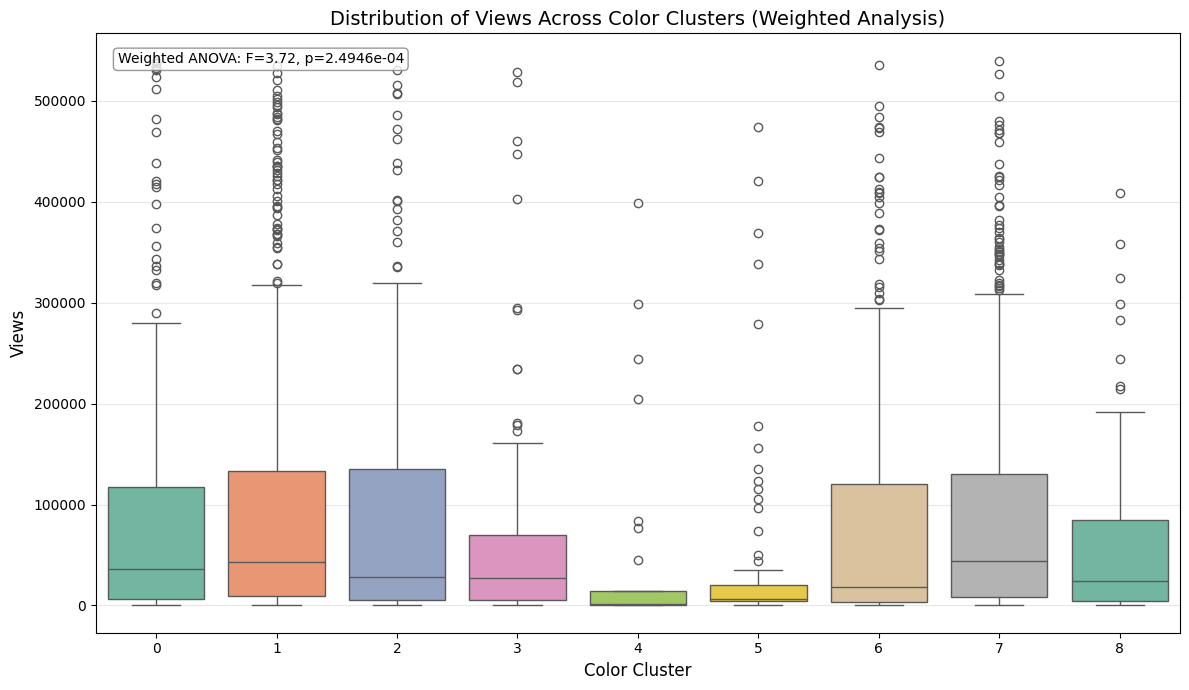

In [150]:
# Create boxplot for Views distribution by Cluster (outliers removed)
plt.figure(figsize=(12, 7))

# Create the boxplot
sns.boxplot(x='Cluster', y='View Count', data=clean_data['View Count'], palette='Set2')

# Style the plot
plt.title('Distribution of Views Across Color Clusters (Weighted Analysis)', fontsize=14)
plt.xlabel('Color Cluster', fontsize=12)
plt.ylabel('Views', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add annotation with weighted ANOVA result
plt.annotate(f'Weighted ANOVA: F={anova_result_views.statistic:.2f}, p={anova_result_views.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', 
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Calculate and print statistics for each cluster
print("\nWeighted Boxplot Statistics for Each Cluster:")
print("-------------------------------------------")
for cluster in sorted(clean_data['View Count']['Cluster'].unique()):
    cluster_data = clean_data['View Count'][clean_data['View Count']['Cluster'] == cluster]
    
    print(f"\nCluster {cluster}")
    print(f"Min: {cluster_data['View Count'].min():,.0f}")
    print(f"Max: {cluster_data['View Count'].max():,.0f}")
    print(f"Median: {cluster_data['View Count'].median():,.0f}")
    print(f"Q1 (25%): {cluster_data['View Count'].quantile(0.25):,.0f}")
    print(f"Q3 (75%): {cluster_data['View Count'].quantile(0.75):,.0f}")
    print(f"Mean: {cluster_data['View Count'].mean():,.0f}")
    print(f"Weighted Mean: {np.average(cluster_data['View Count'], weights=cluster_data['Channel_Weight']):,.0f}")
    print(f"Standard Deviation: {cluster_data['View Count'].std():,.0f}")
    print(f"Number of videos: {len(cluster_data)}")
    print(f"Average channel weight: {cluster_data['Channel_Weight'].mean():.4f}")

plt.tight_layout()
plt.show()

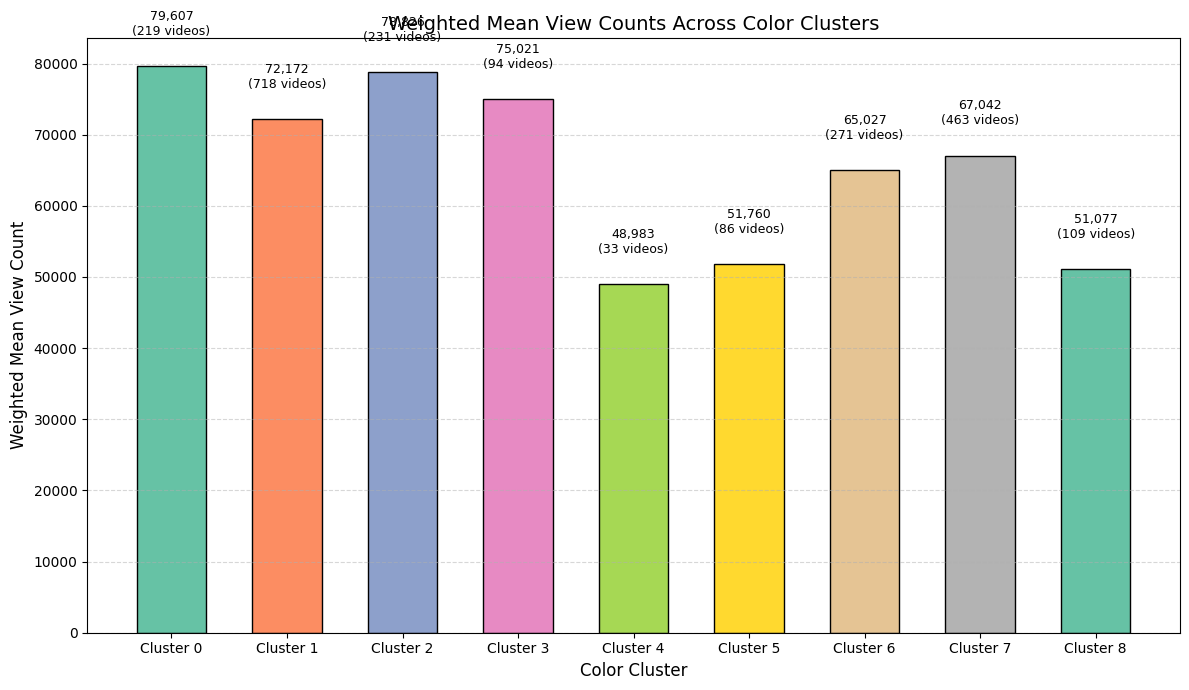

In [151]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get list of all clusters
clusters = sorted(clean_data['View Count']['Cluster'].unique())

# Calculate weighted means and number of videos per cluster
weighted_means = []
video_counts = []

for cluster in clusters:
    cluster_df = clean_data['View Count'][clean_data['View Count']['Cluster'] == cluster]
    views = cluster_df['View Count'].values
    weights = cluster_df['Channel_Weight'].values
    
    if len(views) == 0:
        continue

    # Compute weighted mean
    weighted_mean = np.average(views, weights=weights)
    weighted_means.append(weighted_mean)
    video_counts.append(len(views))

# Create bar-style custom boxplot-like visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Set up positions and width for bars
x_positions = np.arange(len(clusters))
bar_width = 0.6

# Get colors from Seaborn's Set2 palette
colors = sns.color_palette("Set2", len(clusters))

# Plot weighted mean views as bars
bars = ax.bar(x_positions, weighted_means, width=bar_width, color=colors, edgecolor='black')

# Add value labels on top of bars
for i, (bar, count) in enumerate(zip(bars, video_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + (0.05 * max(weighted_means)),
            f'{int(height):,}\n({count} videos)', ha='center', va='bottom', fontsize=9)

# Style the plot
ax.set_title('Weighted Mean View Counts Across Color Clusters', fontsize=14)
ax.set_xlabel('Color Cluster', fontsize=12)
ax.set_ylabel('Weighted Mean View Count', fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels([f"Cluster {c}" for c in clusters])
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate with ANOVA result
# try:
#     anova_result_views
#     ax.annotate(f'Weighted ANOVA: F={anova_result_views.statistic:.2f}, p={anova_result_views.pvalue:.4e}',
#                 xy=(0.02, 0.95), xycoords='axes fraction',
#                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
# except NameError:
#     ax.annotate('Note: ANOVA result not included', xy=(0.02, 0.95), xycoords='axes fraction')

plt.tight_layout()
plt.show()

Perform ANOVA on Like Count

In [152]:
# Perform ANOVA test on Like Count (with outliers removed)
anova_result_likes = f_oneway(*likes_by_Cluster)

# Print results
print("## Weighted ANOVA Results for Likes ##")
print(f"ANOVA F-statistic: {anova_result_likes.statistic:.4f}")
print(f"p-value: {anova_result_likes.pvalue:.4e}")

# Calculate weighted means for each cluster
weighted_means = []
for i, cluster_data in enumerate(likes_by_Cluster):
    cluster_df = clean_data['Like Count'][clean_data['Like Count']['Cluster'] == i]
    weighted_mean = np.average(cluster_data, weights=cluster_df['Channel_Weight'])
    weighted_means.append(weighted_mean)
    print(f"\nCluster {i}:")
    print(f"  Weighted mean likes: {weighted_mean:,.0f}")
    print(f"  Number of videos: {len(cluster_data)}")

# Interpretation
alpha = 0.05
if anova_result_likes.pvalue < alpha:
    print(f"\nRESULT: There are statistically significant differences in Like Count between color Clusters (p < {alpha}).")
    print("This suggests that the weighted like counts differ significantly across clusters.")
else:
    print(f"\nRESULT: No significant differences in Like Count between color Clusters (p > {alpha}).")
    print("This suggests that the weighted like counts are similar across clusters.")

## Weighted ANOVA Results for Likes ##
ANOVA F-statistic: 3.2958
p-value: 9.5238e-04

Cluster 0:
  Weighted mean likes: 2,615
  Number of videos: 221

Cluster 1:
  Weighted mean likes: 2,417
  Number of videos: 738

Cluster 2:
  Weighted mean likes: 2,226
  Number of videos: 234

Cluster 3:
  Weighted mean likes: 2,364
  Number of videos: 95

Cluster 4:
  Weighted mean likes: 1,636
  Number of videos: 34

Cluster 5:
  Weighted mean likes: 1,535
  Number of videos: 88

Cluster 6:
  Weighted mean likes: 2,284
  Number of videos: 275

Cluster 7:
  Weighted mean likes: 2,130
  Number of videos: 462

Cluster 8:
  Weighted mean likes: 1,959
  Number of videos: 109

RESULT: There are statistically significant differences in Like Count between color Clusters (p < 0.05).
This suggests that the weighted like counts differ significantly across clusters.



Weighted Boxplot Statistics for Each Cluster:
-------------------------------------------

Cluster 0
Min: 0
Max: 16,375
Median: 1,293
Q1 (25%): 237
Q3 (75%): 4,662
Mean: 3,176
Weighted Mean: 2,615
Standard Deviation: 4,126
Number of videos: 221
Average channel weight: 0.0006

Cluster 1
Min: 0
Max: 16,857
Median: 1,712
Q1 (25%): 413
Q3 (75%): 4,780
Mean: 3,314
Weighted Mean: 2,417
Standard Deviation: 3,916
Number of videos: 738
Average channel weight: 0.0007

Cluster 2
Min: 0
Max: 16,458
Median: 1,108
Q1 (25%): 123
Q3 (75%): 3,434
Mean: 2,680
Weighted Mean: 2,226
Standard Deviation: 3,762
Number of videos: 234
Average channel weight: 0.0008

Cluster 3
Min: 0
Max: 15,098
Median: 804
Q1 (25%): 247
Q3 (75%): 2,832
Mean: 2,519
Weighted Mean: 2,364
Standard Deviation: 3,429
Number of videos: 95
Average channel weight: 0.0008

Cluster 4
Min: 10
Max: 10,556
Median: 78
Q1 (25%): 26
Q3 (75%): 425
Mean: 1,696
Weighted Mean: 1,636
Standard Deviation: 3,249
Number of videos: 34
Average channel wei

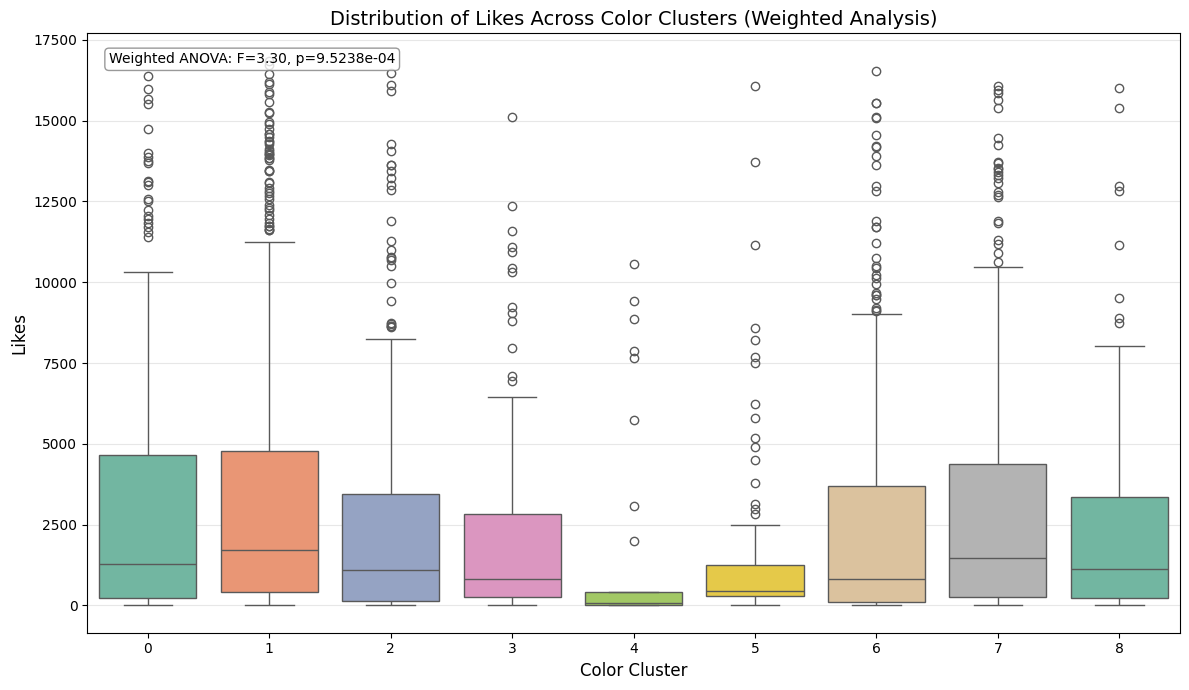

In [153]:
# Create boxplot for Likes distribution by Cluster (outliers removed)
plt.figure(figsize=(12, 7))

# Create the boxplot
sns.boxplot(x='Cluster', y='Like Count', data=clean_data['Like Count'], palette='Set2')

# Style the plot
plt.title('Distribution of Likes Across Color Clusters (Weighted Analysis)', fontsize=14)
plt.xlabel('Color Cluster', fontsize=12)
plt.ylabel('Likes', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add annotation with weighted ANOVA result
plt.annotate(f'Weighted ANOVA: F={anova_result_likes.statistic:.2f}, p={anova_result_likes.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', 
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Calculate and print statistics for each cluster
print("\nWeighted Boxplot Statistics for Each Cluster:")
print("-------------------------------------------")
for cluster in sorted(clean_data['Like Count']['Cluster'].unique()):
    cluster_data = clean_data['Like Count'][clean_data['Like Count']['Cluster'] == cluster]
    
    print(f"\nCluster {cluster}")
    print(f"Min: {cluster_data['Like Count'].min():,.0f}")
    print(f"Max: {cluster_data['Like Count'].max():,.0f}")
    print(f"Median: {cluster_data['Like Count'].median():,.0f}")
    print(f"Q1 (25%): {cluster_data['Like Count'].quantile(0.25):,.0f}")
    print(f"Q3 (75%): {cluster_data['Like Count'].quantile(0.75):,.0f}")
    print(f"Mean: {cluster_data['Like Count'].mean():,.0f}")
    print(f"Weighted Mean: {np.average(cluster_data['Like Count'], weights=cluster_data['Channel_Weight']):,.0f}")
    print(f"Standard Deviation: {cluster_data['Like Count'].std():,.0f}")
    print(f"Number of videos: {len(cluster_data)}")
    print(f"Average channel weight: {cluster_data['Channel_Weight'].mean():.4f}")

plt.tight_layout()
plt.show()

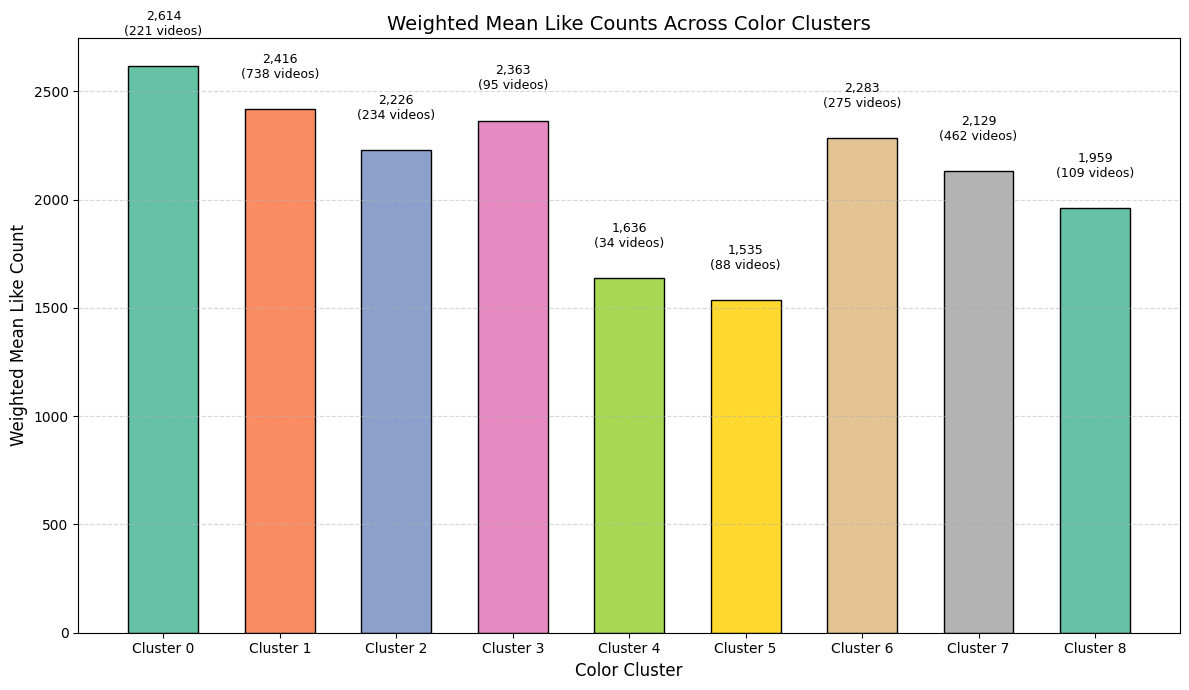

In [129]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get list of all clusters
clusters = sorted(clean_data['Like Count']['Cluster'].unique())

# Calculate weighted means and number of videos per cluster
weighted_means = []
video_counts = []

for cluster in clusters:
    cluster_df = clean_data['Like Count'][clean_data['Like Count']['Cluster'] == cluster]
    likes = cluster_df['Like Count'].values
    weights = cluster_df['Channel_Weight'].values
    
    if len(likes) == 0:
        continue

    # Compute weighted mean
    weighted_mean = np.average(likes, weights=weights)
    weighted_means.append(weighted_mean)
    video_counts.append(len(likes))

# Create bar-style custom boxplot-like visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Set up positions and width for bars
x_positions = np.arange(len(clusters))
bar_width = 0.6

# Get colors from Seaborn's Set2 palette
colors = sns.color_palette("Set2", len(clusters))

# Plot weighted mean likes as bars
bars = ax.bar(x_positions, weighted_means, width=bar_width, color=colors, edgecolor='black')

# Add value labels on top of bars
for i, (bar, count) in enumerate(zip(bars, video_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + (0.05 * max(weighted_means)),
            f'{int(height):,}\n({count} videos)', ha='center', va='bottom', fontsize=9)

# Style the plot
ax.set_title('Weighted Mean Like Counts Across Color Clusters', fontsize=14)
ax.set_xlabel('Color Cluster', fontsize=12)
ax.set_ylabel('Weighted Mean Like Count', fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels([f"Cluster {c}" for c in clusters])
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate with ANOVA result
# ax.annotate(f'Weighted ANOVA: F={anova_result_likes.statistic:.2f}, p={anova_result_likes.pvalue:.4e}',
#             xy=(0.02, 0.95), xycoords='axes fraction',
#             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

plt.tight_layout()
plt.show()

Comment Count

In [130]:
# Perform ANOVA test on Comment Count (with outliers removed)
anova_result_comments = f_oneway(*comments_by_Cluster)

# Print results
print("## Weighted ANOVA Results for Comments ##")
print(f"ANOVA F-statistic: {anova_result_comments.statistic:.4f}")
print(f"p-value: {anova_result_comments.pvalue:.4e}")

# Calculate weighted means for each cluster
weighted_means = []
for i, cluster_data in enumerate(comments_by_Cluster):
    cluster_df = clean_data['Comment Count'][clean_data['Comment Count']['Cluster'] == i]
    weighted_mean = np.average(cluster_data, weights=cluster_df['Channel_Weight'])
    weighted_means.append(weighted_mean)
    print(f"\nCluster {i}:")
    print(f"  Weighted mean comments: {weighted_mean:,.0f}")
    print(f"  Number of videos: {len(cluster_data)}")

# Interpretation
alpha = 0.05
if anova_result_comments.pvalue < alpha:
    print(f"\nRESULT: There are statistically significant differences in Comment Count between color Clusters (p < {alpha}).")
    print("This suggests that the weighted comment counts differ significantly across clusters.")
else:
    print(f"\nRESULT: No significant differences in Comment Count between color Clusters (p > {alpha}).")
    print("This suggests that the weighted comment counts are similar across clusters.")

## Weighted ANOVA Results for Comments ##
ANOVA F-statistic: 3.1132
p-value: 1.6800e-03

Cluster 0:
  Weighted mean comments: 239
  Number of videos: 223

Cluster 1:
  Weighted mean comments: 215
  Number of videos: 715

Cluster 2:
  Weighted mean comments: 202
  Number of videos: 226

Cluster 3:
  Weighted mean comments: 220
  Number of videos: 94

Cluster 4:
  Weighted mean comments: 191
  Number of videos: 34

Cluster 5:
  Weighted mean comments: 119
  Number of videos: 89

Cluster 6:
  Weighted mean comments: 201
  Number of videos: 281

Cluster 7:
  Weighted mean comments: 206
  Number of videos: 464

Cluster 8:
  Weighted mean comments: 189
  Number of videos: 106

RESULT: There are statistically significant differences in Comment Count between color Clusters (p < 0.05).
This suggests that the weighted comment counts differ significantly across clusters.



Weighted Boxplot Statistics for Each Cluster:
-------------------------------------------

Cluster 0
Min: 0
Max: 1,299
Median: 119
Q1 (25%): 30
Q3 (75%): 392
Mean: 269
Weighted Mean: 239
Standard Deviation: 320
Number of videos: 223
Average channel weight: 0.0006

Cluster 1
Min: 0
Max: 1,328
Median: 163
Q1 (25%): 47
Q3 (75%): 352
Mean: 261
Weighted Mean: 215
Standard Deviation: 289
Number of videos: 715
Average channel weight: 0.0007

Cluster 2
Min: 0
Max: 1,320
Median: 118
Q1 (25%): 32
Q3 (75%): 334
Mean: 229
Weighted Mean: 202
Standard Deviation: 275
Number of videos: 226
Average channel weight: 0.0008

Cluster 3
Min: 0
Max: 1,188
Median: 104
Q1 (25%): 43
Q3 (75%): 251
Mean: 230
Weighted Mean: 220
Standard Deviation: 292
Number of videos: 94
Average channel weight: 0.0008

Cluster 4
Min: 1
Max: 1,196
Median: 20
Q1 (25%): 12
Q3 (75%): 103
Mean: 129
Weighted Mean: 191
Standard Deviation: 252
Number of videos: 34
Average channel weight: 0.0007

Cluster 5
Min: 0
Max: 918
Median: 70
Q1 (

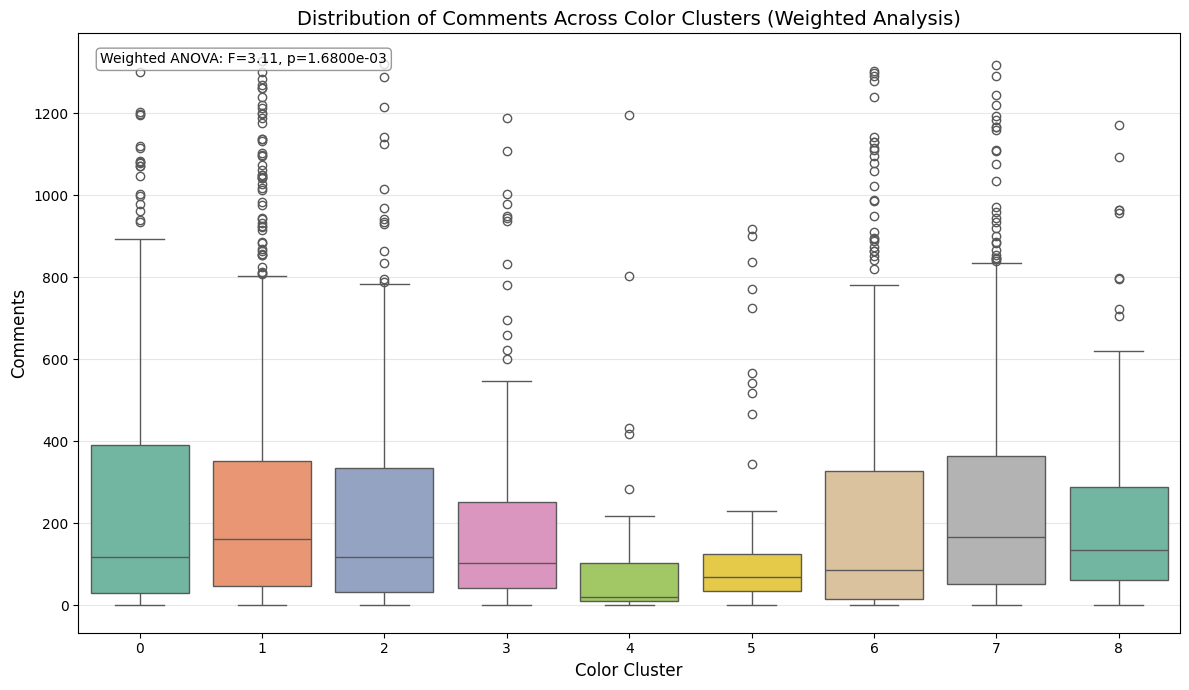

In [84]:
# Create boxplot for Comments distribution by Cluster (outliers removed)
plt.figure(figsize=(12, 7))

# Create the boxplot
sns.boxplot(x='Cluster', y='Comment Count', data=clean_data['Comment Count'], palette='Set2')

# Style the plot
plt.title('Distribution of Comments Across Color Clusters (Weighted Analysis)', fontsize=14)
plt.xlabel('Color Cluster', fontsize=12)
plt.ylabel('Comments', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add annotation with weighted ANOVA result
plt.annotate(f'Weighted ANOVA: F={anova_result_comments.statistic:.2f}, p={anova_result_comments.pvalue:.4e}', 
            xy=(0.02, 0.95), xycoords='axes fraction', 
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Calculate and print statistics for each cluster
print("\nWeighted Boxplot Statistics for Each Cluster:")
print("-------------------------------------------")
for cluster in sorted(clean_data['Comment Count']['Cluster'].unique()):
    cluster_data = clean_data['Comment Count'][clean_data['Comment Count']['Cluster'] == cluster]
    
    print(f"\nCluster {cluster}")
    print(f"Min: {cluster_data['Comment Count'].min():,.0f}")
    print(f"Max: {cluster_data['Comment Count'].max():,.0f}")
    print(f"Median: {cluster_data['Comment Count'].median():,.0f}")
    print(f"Q1 (25%): {cluster_data['Comment Count'].quantile(0.25):,.0f}")
    print(f"Q3 (75%): {cluster_data['Comment Count'].quantile(0.75):,.0f}")
    print(f"Mean: {cluster_data['Comment Count'].mean():,.0f}")
    print(f"Weighted Mean: {np.average(cluster_data['Comment Count'], weights=cluster_data['Channel_Weight']):,.0f}")
    print(f"Standard Deviation: {cluster_data['Comment Count'].std():,.0f}")
    print(f"Number of videos: {len(cluster_data)}")
    print(f"Average channel weight: {cluster_data['Channel_Weight'].mean():.4f}")

plt.tight_layout()
plt.show()

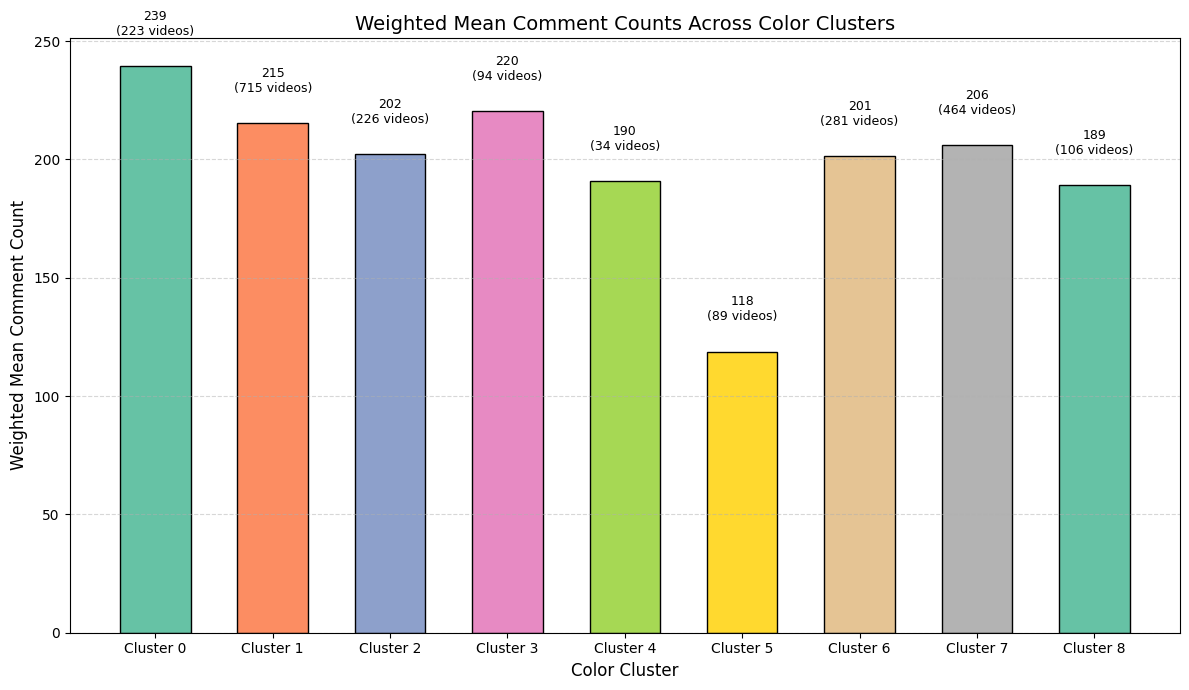

In [131]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get list of all clusters
clusters = sorted(clean_data['Comment Count']['Cluster'].unique())

# Calculate weighted means and number of videos per cluster
weighted_means = []
video_counts = []

for cluster in clusters:
    cluster_df = clean_data['Comment Count'][clean_data['Comment Count']['Cluster'] == cluster]
    comments = cluster_df['Comment Count'].values
    weights = cluster_df['Channel_Weight'].values
    
    if len(comments) == 0:
        continue

    # Compute weighted mean
    weighted_mean = np.average(comments, weights=weights)
    weighted_means.append(weighted_mean)
    video_counts.append(len(comments))

# Create bar-style custom boxplot-like visualization
fig, ax = plt.subplots(figsize=(12, 7))

# Set up positions and width for bars
x_positions = np.arange(len(clusters))
bar_width = 0.6

# Get colors from Seaborn's Set2 palette
colors = sns.color_palette("Set2", len(clusters))

# Plot weighted mean comments as bars
bars = ax.bar(x_positions, weighted_means, width=bar_width, color=colors, edgecolor='black')

# Add value labels on top of bars
for i, (bar, count) in enumerate(zip(bars, video_counts)):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + (0.05 * max(weighted_means)),
            f'{int(height):,}\n({count} videos)', ha='center', va='bottom', fontsize=9)

# Style the plot
ax.set_title('Weighted Mean Comment Counts Across Color Clusters', fontsize=14)
ax.set_xlabel('Color Cluster', fontsize=12)
ax.set_ylabel('Weighted Mean Comment Count', fontsize=12)
ax.set_xticks(x_positions)
ax.set_xticklabels([f"Cluster {c}" for c in clusters])
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate with ANOVA result
# try:
#     anova_result_comments
#     ax.annotate(f'Weighted ANOVA: F={anova_result_comments.statistic:.2f}, p={anova_result_comments.pvalue:.4e}',
#                 xy=(0.02, 0.95), xycoords='axes fraction',
#                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))
# except NameError:
#     ax.annotate('Note: ANOVA result not included', xy=(0.02, 0.95), xycoords='axes fraction')

plt.tight_layout()
plt.show()

Using the Post-hoc Bonferroni correction to identify which specific clusters differ from each other.

In [160]:
from scipy.stats import ttest_ind
from itertools import combinations

# Load clean_data['View Count'] (already outlier-removed)
clean_view_data = clean_data['View Count'].copy()

# Define significance level
alpha = 0.05
n_clusters = len(clean_view_data['Cluster'].unique())
num_comparisons = n_clusters * (n_clusters - 1) // 2  # Total pairwise comparisons
bonferroni_alpha = alpha / num_comparisons  # Adjusted threshold

print(f"## Weighted Post-Hoc Comparison: View Count ##")
print(f"Number of clusters: {n_clusters}")
print(f"Total pairwise comparisons: {num_comparisons}")
print(f"Bonferroni-corrected alpha: {bonferroni_alpha:.6f}")
print(f"{'-'*60}")

# Store results
post_hoc_results = []

# Get all cluster pairs
clusters = sorted(clean_view_data['Cluster'].unique())

for cluster_i, cluster_j in combinations(clusters, 2):
    # Extract data for each cluster
    df_i = clean_view_data[clean_view_data['Cluster'] == cluster_i]
    df_j = clean_view_data[clean_view_data['Cluster'] == cluster_j]
    
    if len(df_i) == 0 or len(df_j) == 0:
        continue

    # Compute weighted means
    mean_i = np.average(df_i['View Count'], weights=df_i['Channel_Weight'])
    mean_j = np.average(df_j['View Count'], weights=df_j['Channel_Weight'])
    
    # Compute difference
    diff = mean_i - mean_j

    # Perform unweighted t-test (Welch's t-test) — best available proxy
    t_stat, p_value = ttest_ind(df_i['View Count'], df_j['View Count'], equal_var=False)

    # Apply Bonferroni correction
    significant = p_value < bonferroni_alpha

    post_hoc_results.append({
        'Cluster_i': cluster_i,
        'Cluster_j': cluster_j,
        'Mean_i': round(mean_i, 2),
        'Mean_j': round(mean_j, 2),
        'Diff': round(diff, 2),
        't_stat': round(t_stat, 4),
        'p_value': round(p_value, 6),
        'p_adj_threshold': round(bonferroni_alpha, 6),
        'significant': significant
    })

# Convert to DataFrame
results_df = pd.DataFrame(post_hoc_results)

# Sort by absolute difference (largest first)
results_df = results_df.sort_values('Diff', key=abs, ascending=False).reset_index(drop=True)

# Print weighted mean view counts for reference
print("\nWeighted Mean View Counts by Cluster:")
for cluster in clusters:
    cluster_df = clean_view_data[clean_view_data['Cluster'] == cluster]
    weighted_mean = np.average(cluster_df['View Count'], weights=cluster_df['Channel_Weight'])
    print(f"  Cluster {cluster}: {weighted_mean:,.0f} views")

# Print all 36 comparisons
print(f"\n{'='*80}")
print("ALL PAIRWISE COMPARISONS (Sorted by |Difference|, Largest First)")
print(f"{'='*80}")
print(f"{'Cluster Pair':<12} {'Mean_i':>12} {'Mean_j':>12} {'Diff':>12} {'p-value':>12} {'Significant':>12}")
print(f"{'-'*80}")
for _, row in results_df.iterrows():
    sig_str = "Yes" if row['significant'] else "No"
    print(f"({row['Cluster_i']} vs {row['Cluster_j']}): "
          f"{row['Mean_i']:>12,.0f} "
          f"{row['Mean_j']:>12,.0f} "
          f"{row['Diff']:>12,.0f} "
          f"{row['p_value']:>12.6f} "
          f"{sig_str:>12}")

# Summary of significant results
significant_count = results_df['significant'].sum()
print(f"\nSummary:")
print(f"Total comparisons: {len(results_df)}")
print(f"Significant differences (p < {bonferroni_alpha:.6f}): {significant_count}")
if significant_count == 0:
    print("No pairwise differences reached statistical significance after Bonferroni correction.")
else:
    print(f"Significant pairs: ")
    sig_pairs = results_df[results_df['significant']][['Cluster_i', 'Cluster_j', 'Diff', 'p_value']]
    for _, row in sig_pairs.iterrows():
        print(f"  Cluster {row['Cluster_i']} vs {row['Cluster_j']}: Δ = {row['Diff']:+,.0f}, p = {row['p_value']:.2e}")

## Weighted Post-Hoc Comparison: View Count ##
Number of clusters: 9
Total pairwise comparisons: 36
Bonferroni-corrected alpha: 0.001389
------------------------------------------------------------

Weighted Mean View Counts by Cluster:
  Cluster 0: 79,608 views
  Cluster 1: 72,173 views
  Cluster 2: 78,826 views
  Cluster 3: 75,021 views
  Cluster 4: 48,984 views
  Cluster 5: 51,761 views
  Cluster 6: 65,027 views
  Cluster 7: 67,043 views
  Cluster 8: 51,078 views

ALL PAIRWISE COMPARISONS (Sorted by |Difference|, Largest First)
Cluster Pair       Mean_i       Mean_j         Diff      p-value  Significant
--------------------------------------------------------------------------------
(0 vs 4):       79,608       48,984       30,624     0.008356           No
(2 vs 4):       78,826       48,984       29,843     0.023120           No
(0 vs 8):       79,608       51,078       28,530     0.003769           No
(0 vs 5):       79,608       51,761       27,847     0.000062          Yes
(2 v

In [ ]:
# Load clean_data['Like Count'] (already outlier-removed)
clean_like_data = clean_data['Like Count'].copy()

# Define significance level
alpha = 0.05
n_clusters = len(clean_like_data['Cluster'].unique())
num_comparisons = n_clusters * (n_clusters - 1) // 2  # Total pairwise comparisons
bonferroni_alpha = alpha / num_comparisons  # Adjusted threshold

print(f"## Weighted Post-Hoc Comparison: Like Count ##")
print(f"Number of clusters: {n_clusters}")
print(f"Total pairwise comparisons: {num_comparisons}")
print(f"Bonferroni-corrected alpha: {bonferroni_alpha:.6f}")
print(f"{'-'*60}")

# Store results
post_hoc_results = []

# Get all cluster pairs
clusters = sorted(clean_like_data['Cluster'].unique())

for cluster_i, cluster_j in combinations(clusters, 2):
    # Extract data for each cluster
    df_i = clean_like_data[clean_like_data['Cluster'] == cluster_i]
    df_j = clean_like_data[clean_like_data['Cluster'] == cluster_j]
    
    if len(df_i) == 0 or len(df_j) == 0:
        continue

    # Compute weighted means
    mean_i = np.average(df_i['Like Count'], weights=df_i['Channel_Weight'])
    mean_j = np.average(df_j['Like Count'], weights=df_j['Channel_Weight'])
    
    # Compute difference
    diff = mean_i - mean_j

    # Perform unweighted t-test (Welch's t-test) — best available proxy
    t_stat, p_value = ttest_ind(df_i['Like Count'], df_j['Like Count'], equal_var=False)

    # Apply Bonferroni correction: mark as significant if p < adjusted alpha
    significant = p_value < bonferroni_alpha

    post_hoc_results.append({
        'Cluster_i': cluster_i,
        'Cluster_j': cluster_j,
        'Mean_i': round(mean_i, 2),
        'Mean_j': round(mean_j, 2),
        'Diff': round(diff, 2),
        't_stat': round(t_stat, 4),
        'p_value': round(p_value, 6),
        'p_adj_threshold': round(bonferroni_alpha, 6),
        'significant': significant
    })

# Convert to DataFrame
results_df = pd.DataFrame(post_hoc_results)

# Sort by absolute difference (largest first)
results_df = results_df.sort_values('Diff', key=abs, ascending=False).reset_index(drop=True)

# Print weighted mean like counts for reference
print("\nWeighted Mean Like Counts by Cluster:")
for cluster in clusters:
    cluster_df = clean_like_data[clean_like_data['Cluster'] == cluster]
    weighted_mean = np.average(cluster_df['Like Count'], weights=cluster_df['Channel_Weight'])
    print(f"  Cluster {cluster}: {weighted_mean:,.0f} likes")

# Print all 36 comparisons
print(f"\n{'='*80}")
print("ALL PAIRWISE COMPARISONS (Sorted by |Difference|, Largest First)")
print(f"{'='*80}")
print(f"{'Cluster Pair':<12} {'Mean_i':>10} {'Mean_j':>10} {'Diff':>10} {'p-value':>12} {'Significant':>12}")
print(f"{'-'*80}")
for _, row in results_df.iterrows():
    sig_str = "Yes" if row['significant'] else "No"
    print(f"({row['Cluster_i']} vs {row['Cluster_j']}): "
          f"{row['Mean_i']:>10.0f} "
          f"{row['Mean_j']:>10.0f} "
          f"{row['Diff']:>10.0f} "
          f"{row['p_value']:>12.6f} "
          f"{sig_str:>12}")

# Summary of significant results
significant_count = results_df['significant'].sum()
print(f"\nSummary:")
print(f"Total comparisons: {len(results_df)}")
print(f"Significant differences (p < {bonferroni_alpha:.6f}): {significant_count}")
if significant_count == 0:
    print("No pairwise differences reached statistical significance after Bonferroni correction.")
else:
    print(f"Significant pairs: ")
    sig_pairs = results_df[results_df['significant']][['Cluster_i', 'Cluster_j', 'Diff', 'p_value']]
    for _, row in sig_pairs.iterrows():
        print(f"  Cluster {row['Cluster_i']} vs {row['Cluster_j']}: Δ = {row['Diff']:+.0f}, p = {row['p_value']:.2e}")

## Weighted Post-Hoc Comparison: Like Count ##
Number of clusters: 9
Total pairwise comparisons: 36
Bonferroni-corrected alpha: 0.001389
------------------------------------------------------------

Weighted Mean Like Counts by Cluster:
  Cluster 0: 2,615 likes
  Cluster 1: 2,417 likes
  Cluster 2: 2,226 likes
  Cluster 3: 2,364 likes
  Cluster 4: 1,636 likes
  Cluster 5: 1,535 likes
  Cluster 6: 2,284 likes
  Cluster 7: 2,130 likes
  Cluster 8: 1,959 likes

ALL PAIRWISE COMPARISONS (Sorted by |Difference|, Largest First)
Cluster Pair     Mean_i     Mean_j       Diff      p-value  Significant
--------------------------------------------------------------------------------
(0 vs 5):       2615       1535       1080     0.000472          Yes
(0 vs 4):       2615       1636        979     0.021201           No
(1 vs 5):       2417       1535        882     0.000008          Yes
(3 vs 5):       2364       1535        829     0.074989           No
(1 vs 4):       2417       1636        781 

In [161]:
from scipy.stats import ttest_ind
from itertools import combinations

# Load clean_data['Comment Count'] (already outlier-removed)
clean_comment_data = clean_data['Comment Count'].copy()

# Define significance level
alpha = 0.05
n_clusters = len(clean_comment_data['Cluster'].unique())
num_comparisons = n_clusters * (n_clusters - 1) // 2  # Total pairwise comparisons
bonferroni_alpha = alpha / num_comparisons  # Adjusted threshold

print(f"## Weighted Post-Hoc Comparison: Comment Count ##")
print(f"Number of clusters: {n_clusters}")
print(f"Total pairwise comparisons: {num_comparisons}")
print(f"Bonferroni-corrected alpha: {bonferroni_alpha:.6f}")
print(f"{'-'*60}")

# Store results
post_hoc_results = []

# Get all cluster pairs
clusters = sorted(clean_comment_data['Cluster'].unique())

for cluster_i, cluster_j in combinations(clusters, 2):
    # Extract data for each cluster
    df_i = clean_comment_data[clean_comment_data['Cluster'] == cluster_i]
    df_j = clean_comment_data[clean_comment_data['Cluster'] == cluster_j]
    
    if len(df_i) == 0 or len(df_j) == 0:
        continue

    # Compute weighted means
    mean_i = np.average(df_i['Comment Count'], weights=df_i['Channel_Weight'])
    mean_j = np.average(df_j['Comment Count'], weights=df_j['Channel_Weight'])
    
    # Compute difference
    diff = mean_i - mean_j

    # Perform unweighted t-test (Welch's t-test)
    t_stat, p_value = ttest_ind(df_i['Comment Count'], df_j['Comment Count'], equal_var=False)

    # Apply Bonferroni correction
    significant = p_value < bonferroni_alpha

    post_hoc_results.append({
        'Cluster_i': cluster_i,
        'Cluster_j': cluster_j,
        'Mean_i': round(mean_i, 2),
        'Mean_j': round(mean_j, 2),
        'Diff': round(diff, 2),
        't_stat': round(t_stat, 4),
        'p_value': round(p_value, 6),
        'p_adj_threshold': round(bonferroni_alpha, 6),
        'significant': significant
    })

# Convert to DataFrame
results_df = pd.DataFrame(post_hoc_results)

# Sort by absolute difference (largest first)
results_df = results_df.sort_values('Diff', key=abs, ascending=False).reset_index(drop=True)

# Print weighted mean comment counts for reference
print("\nWeighted Mean Comment Counts by Cluster:")
for cluster in clusters:
    cluster_df = clean_comment_data[clean_comment_data['Cluster'] == cluster]
    weighted_mean = np.average(cluster_df['Comment Count'], weights=cluster_df['Channel_Weight'])
    print(f"  Cluster {cluster}: {weighted_mean:,.0f} comments")

# Print all 36 comparisons
print(f"\n{'='*80}")
print("ALL PAIRWISE COMPARISONS (Sorted by |Difference|, Largest First)")
print(f"{'='*80}")
print(f"{'Cluster Pair':<12} {'Mean_i':>12} {'Mean_j':>12} {'Diff':>12} {'p-value':>12} {'Significant':>12}")
print(f"{'-'*80}")
for _, row in results_df.iterrows():
    sig_str = "Yes" if row['significant'] else "No"
    print(f"({row['Cluster_i']} vs {row['Cluster_j']}): "
          f"{row['Mean_i']:>12,.0f} "
          f"{row['Mean_j']:>12,.0f} "
          f"{row['Diff']:>12,.0f} "
          f"{row['p_value']:>12.6f} "
          f"{sig_str:>12}")

# Summary of significant results
significant_count = results_df['significant'].sum()
print(f"\nSummary:")
print(f"Total comparisons: {len(results_df)}")
print(f"Significant differences (p < {bonferroni_alpha:.6f}): {significant_count}")
if significant_count == 0:
    print("No pairwise differences reached statistical significance after Bonferroni correction.")
else:
    print(f"Significant pairs: ")
    sig_pairs = results_df[results_df['significant']][['Cluster_i', 'Cluster_j', 'Diff', 'p_value']]
    for _, row in sig_pairs.iterrows():
        print(f"  Cluster {row['Cluster_i']} vs {row['Cluster_j']}: Δ = {row['Diff']:+,.0f}, p = {row['p_value']:.2e}")

## Weighted Post-Hoc Comparison: Comment Count ##
Number of clusters: 9
Total pairwise comparisons: 36
Bonferroni-corrected alpha: 0.001389
------------------------------------------------------------

Weighted Mean Comment Counts by Cluster:
  Cluster 0: 239 comments
  Cluster 1: 215 comments
  Cluster 2: 202 comments
  Cluster 3: 220 comments
  Cluster 4: 191 comments
  Cluster 5: 119 comments
  Cluster 6: 201 comments
  Cluster 7: 206 comments
  Cluster 8: 189 comments

ALL PAIRWISE COMPARISONS (Sorted by |Difference|, Largest First)
Cluster Pair       Mean_i       Mean_j         Diff      p-value  Significant
--------------------------------------------------------------------------------
(0 vs 5):          239          119          121     0.000024          Yes
(3 vs 5):          220          119          102     0.013864           No
(1 vs 5):          215          119           97     0.000001          Yes
(5 vs 7):          119          206          -87     0.000002          Ye

Look into the suscribers count of the top 5 channels with the most video in each cluster. 

Clusters in top5_per_cluster: ['0' '1' '2' '3' '4' '5' '6' '7' '8']
Cluster
0    5
1    5
2    5
3    5
4    5
5    5
6    5
7    5
8    5
dtype: int64
   Cluster                              Channel Name  Subscriber Count
0        0                           music game news         1210000.0
1        0                                 nic & rei           14700.0
2        0                              pinoy planet           97800.0
3        0                 adam and jane's lifestyle           75500.0
4        0                                 kim n lee           95200.0
10       1                           waleska herrera         1230000.0
11       1                 adam and jane's lifestyle           75500.0
12       1                             the commodity           98300.0
13       1                              pinoy planet           97800.0
14       1                      the demouchets react          182000.0
20       2                     japapino world ジャパピーノ          17400

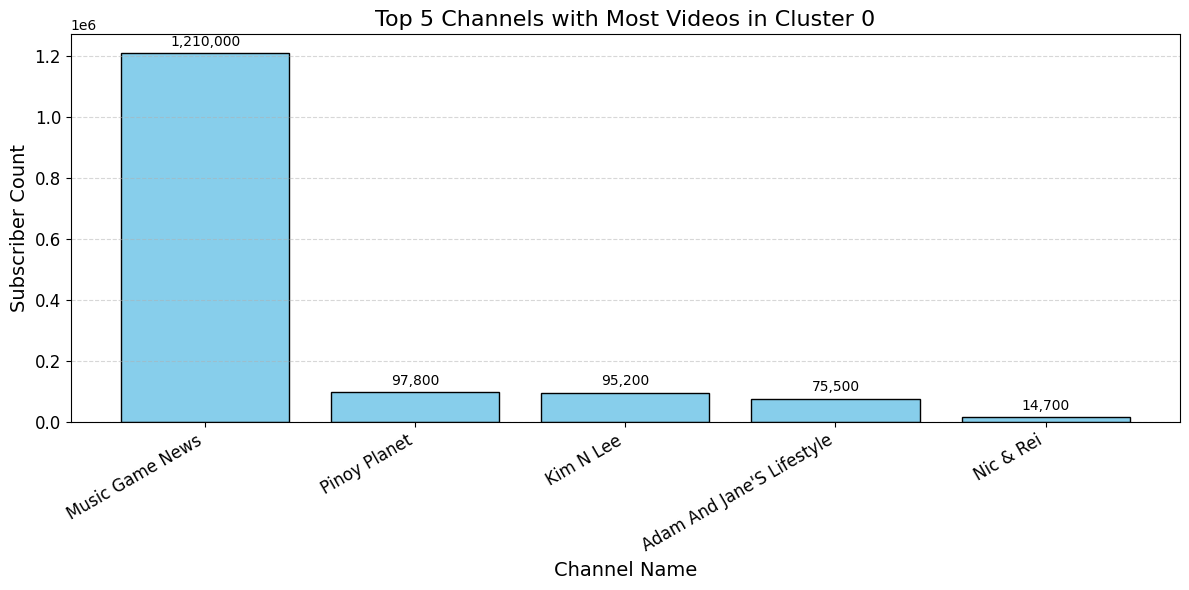

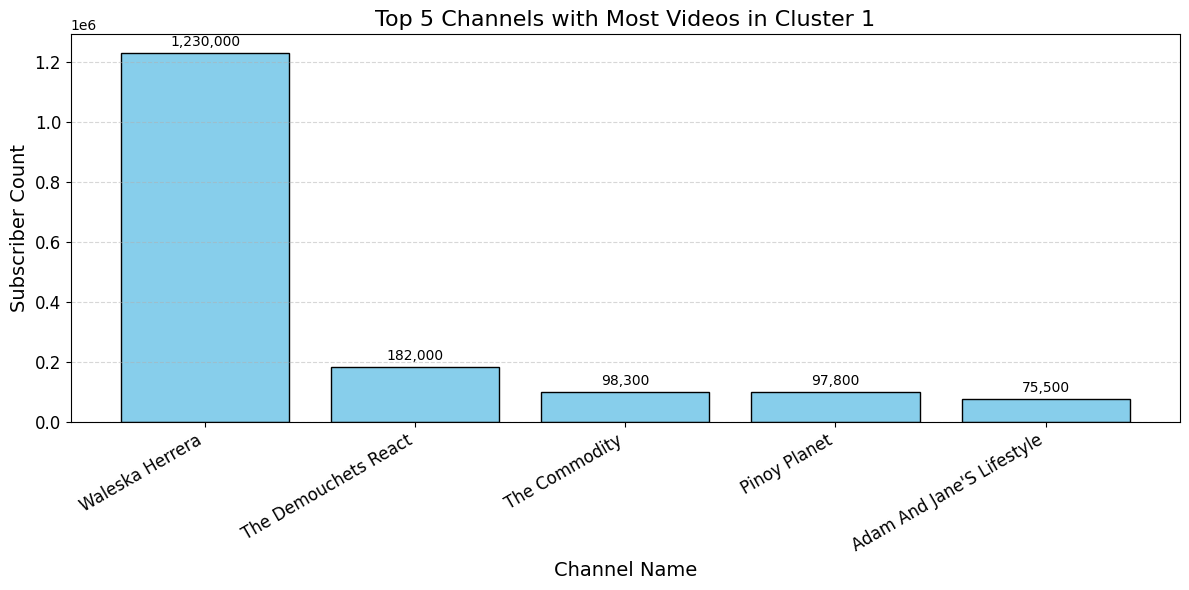

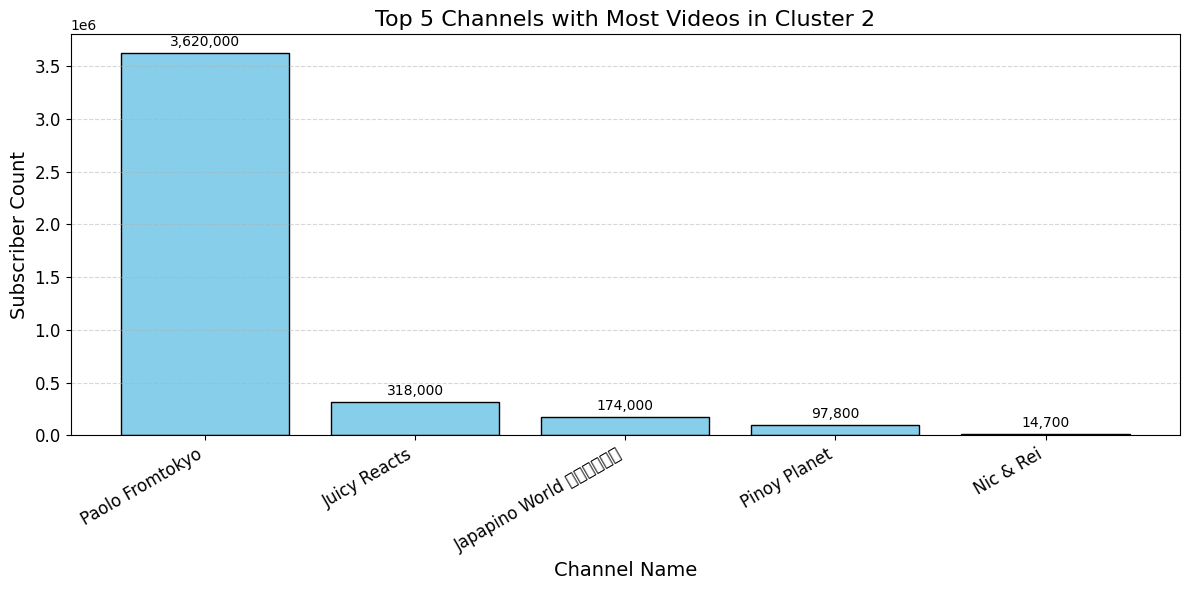

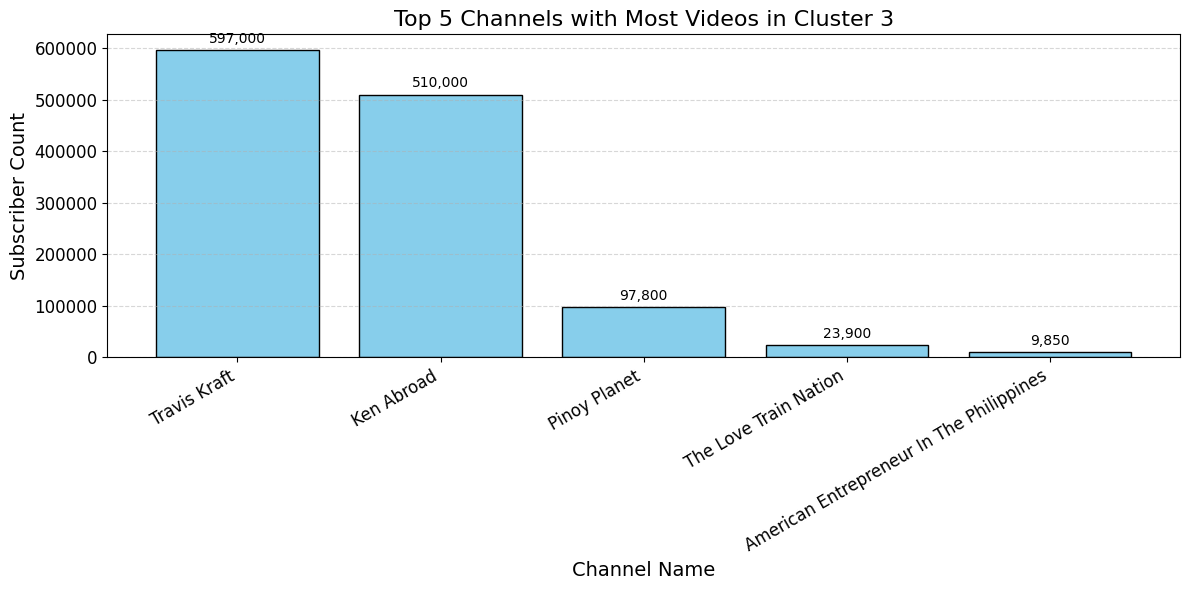

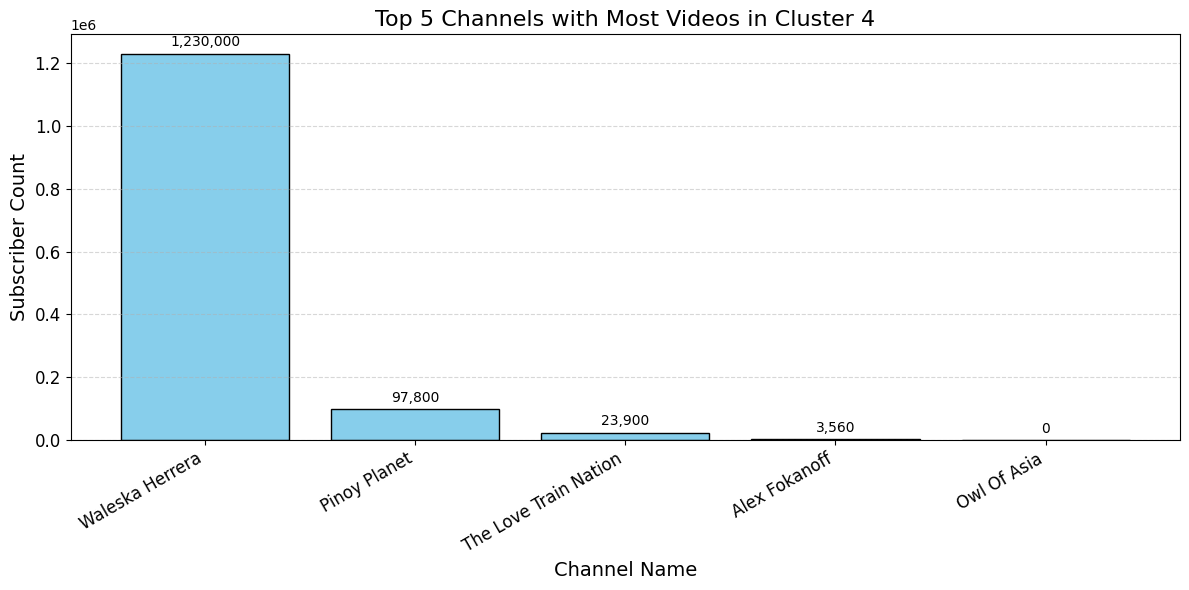

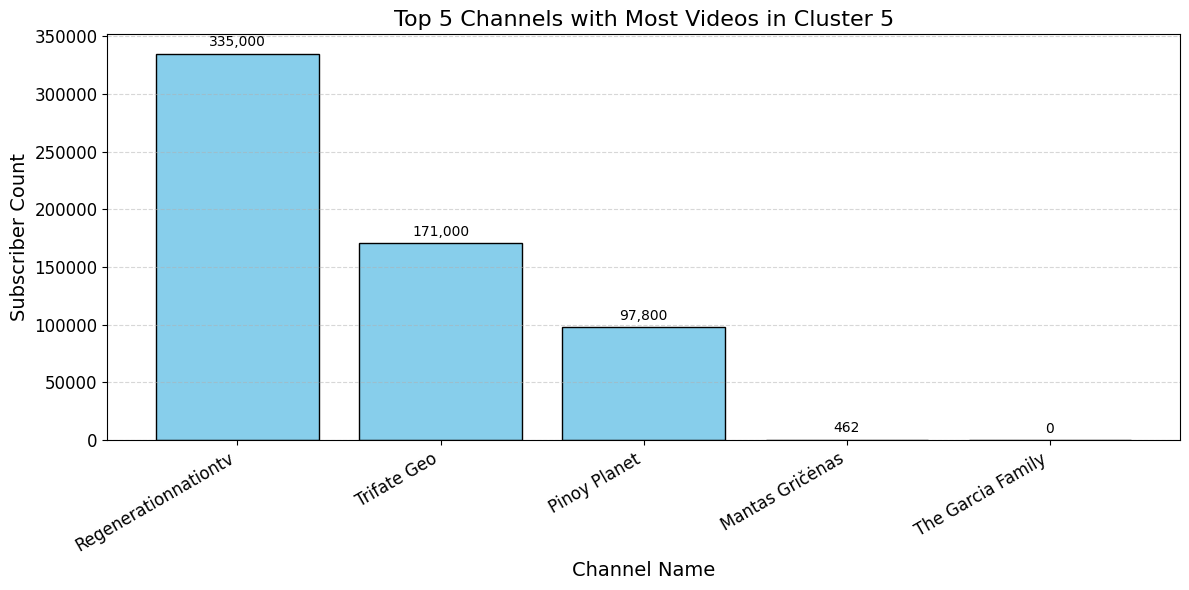

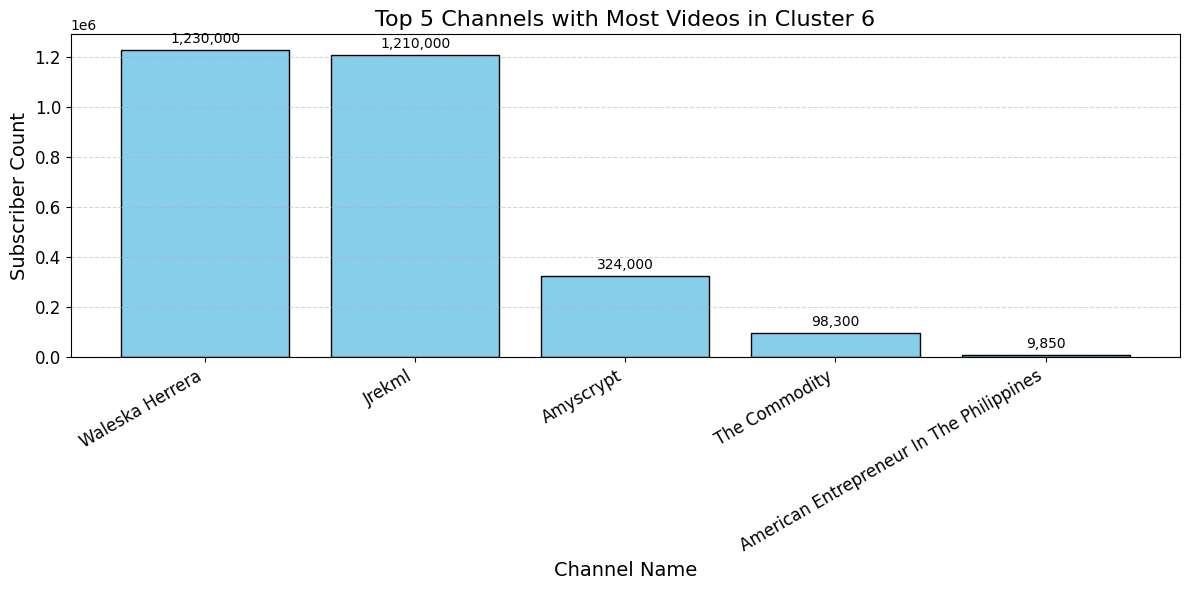

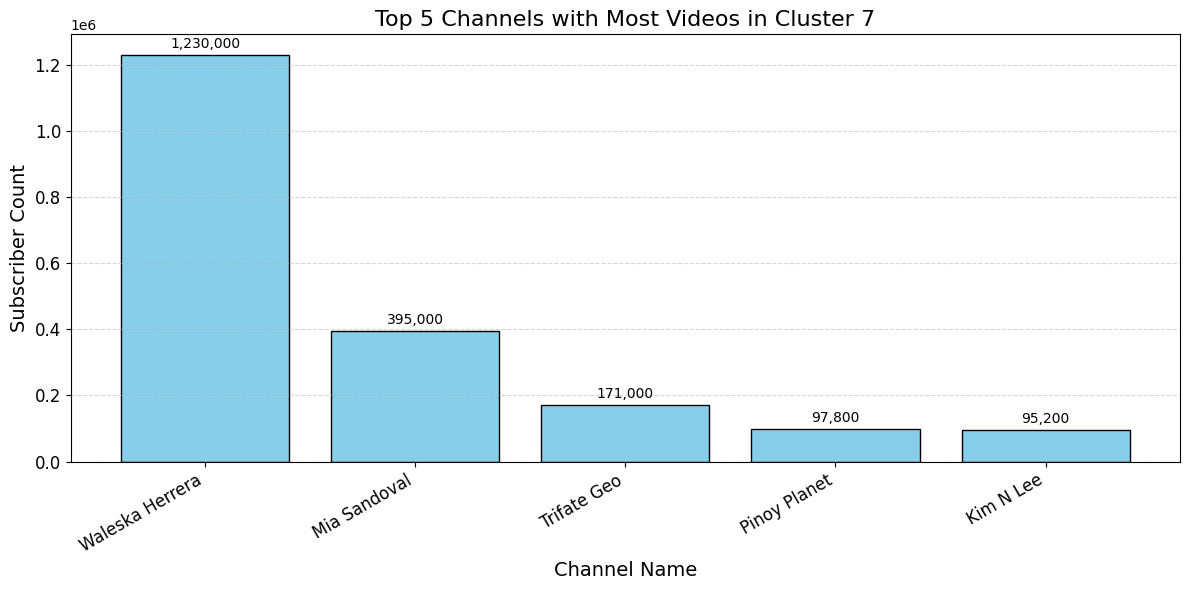

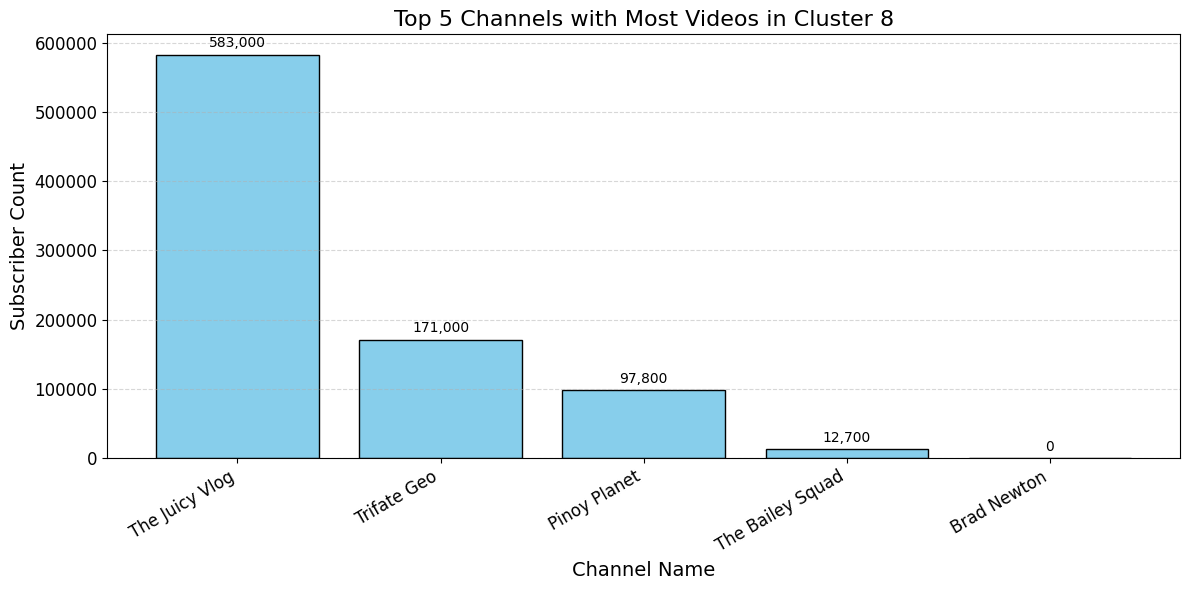

In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Parse the top channels CSV
rows = []
current_cluster = None

with open("Final_clustering/K=9/Correlational/top_channels_per_cluster.csv", encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if line.startswith("Cluster"):
            match = re.search(r'Cluster\s+(\d+)', line)
            if match:
                current_cluster = match.group(1)
        elif line.startswith(',') and ',' in line:
            parts = line.split(',')
            if len(parts) >= 3 and current_cluster is not None:
                channel = parts[1].strip()
                try:
                    video_count = int(parts[2])
                except ValueError:
                    video_count = None
                rows.append({
                    'Cluster': current_cluster,
                    'Channel Name': channel,
                    'Video Count': video_count
                })

top_channels_df = pd.DataFrame(rows)

# 2. Load subscriber data
subs = pd.read_csv("Final_clustering/Final_Suscribers_Count.csv")

# 3. Clean and standardize channel names for merging
top_channels_df['Channel Name'] = top_channels_df['Channel Name'].str.strip().str.lower()
subs['Channel Name'] = subs['Channel Name'].str.strip().str.lower()

# 4. Merge on 'Channel Name'
merged = top_channels_df.merge(subs[['Channel Name', 'Subscriber Count']], on='Channel Name', how='left')

# 5. For each cluster, select the top 5 channels by Video Count
top5_per_cluster = (
    merged.sort_values(['Cluster', 'Video Count'], ascending=[True, False])
    .groupby('Cluster')
    .head(5)
)

# 6. Diagnostics: print which clusters have data
print("Clusters in top5_per_cluster:", top5_per_cluster['Cluster'].unique())
print(top5_per_cluster.groupby('Cluster').size())
print(top5_per_cluster[['Cluster', 'Channel Name', 'Subscriber Count']])

# 7. Fill missing subscriber counts with 0 for plotting
top5_per_cluster['Subscriber Count'] = top5_per_cluster['Subscriber Count'].fillna(0)

# 8. Plotting: one figure per cluster, only top 5 channels
clusters = sorted(top5_per_cluster['Cluster'].unique(), key=lambda x: int(x))

for cluster in clusters:
    data = top5_per_cluster[top5_per_cluster['Cluster'] == cluster].sort_values('Subscriber Count', ascending=False)
    plt.figure(figsize=(12, 6))
    bars = plt.bar(data['Channel Name'].str.title(), data['Subscriber Count'], color='skyblue', edgecolor='black')
    plt.title(f"Top 5 Channels with Most Videos in Cluster {cluster}", fontsize=16)
    plt.xlabel("Channel Name", fontsize=14)
    plt.ylabel("Subscriber Count", fontsize=14)
    plt.xticks(rotation=30, ha='right', fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{int(height):,}', xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)
    plt.show()

Get the Average Suscriber Count of Each Cluster


In [110]:
# Calculate and print total subscriber count for top 5 channels in each cluster
print("Total Subscriber Count")
for cluster in sorted(top5_per_cluster['Cluster'].unique(), key=lambda x: int(x)):
    data = top5_per_cluster[top5_per_cluster['Cluster'] == cluster]
    total = int(data['Subscriber Count'].sum())
    print(f"Cluster {cluster}: {total:,}")

Total Subscriber Count
Cluster 0: 1,493,200
Cluster 1: 1,683,600
Cluster 2: 4,224,500
Cluster 3: 1,238,550
Cluster 4: 1,355,260
Cluster 5: 604,262
Cluster 6: 2,872,150
Cluster 7: 1,989,000
Cluster 8: 864,500


## Code for non weighted color and channel ##

In [1]:

import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import f_oneway
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')  # Suppress warnings for cleaner output


In [2]:
# Combine all Cluster data and color profile percentage into one DataFrame
color_profile_data = pd.read_csv('Final_Clustering/K=9/Cluster_Color_Profile_Final.csv')

# Load video engagement data
video_data = pd.read_csv('Final_Clustering/Results_Count_Final.csv')

# Remove the .jpg extension from the VideoID in color_profile_data
color_profile_data['VideoID'] = color_profile_data['VideoID'].str.replace('.jpg', '')

# Check again after cleaning
print("\nCleaned Sample IDs from color_profile_data:")
print(color_profile_data['VideoID'].head())

# Merge datasets on 'Video ID'
merged_data = pd.merge(color_profile_data, video_data, on='VideoID', how='inner')

# Read the results_final.csv file
results_df = pd.read_csv('results_final.csv')

# Rename the 'Video Id' column to 'VideoID' in results_df to match merged_data
results_df = results_df.rename(columns={'Video Id': 'VideoID'})

# Merge the Channel Title from results_df into merged_data
merged_data = pd.merge(merged_data, results_df[['VideoID', 'Channel Title']], on='VideoID', how='inner')


# Check the merged dataset
print("\nMerged Dataset:")
print(merged_data.head())

# Display the number of rows and columns
print("\nNumber of rows and columns:", merged_data.shape)

# Define which video metric columns to analyze
metric_columns_for_anova = ['View Count', 'Like Count', 'Comment Count']
print(f"Metrics selected for analysis: {', '.join(metric_columns_for_anova)}")


Cleaned Sample IDs from color_profile_data:
0    --8n6A8Q6M0
1    -0FfyNZdHk0
2    -1B7cVoZr1c
3    -4yu_13EHFM
4    -6FvAU9H98w
Name: VideoID, dtype: object

Merged Dataset:
       VideoID  Yellow  Orange  Red  Violet  Blue  Green  Black  White  Brown  \
0  --8n6A8Q6M0    0.00    0.71  0.0   23.29  0.06   0.00  13.58  13.01  49.35   
1  -0FfyNZdHk0    0.01    0.97  0.0   11.65  0.00   8.13  26.25  13.26  39.73   
2  -1B7cVoZr1c    0.84    0.61  0.0   16.56  7.08   0.00  14.65  32.05  28.21   
3  -4yu_13EHFM    0.00    8.72  0.0   25.99  0.00   0.00  14.83  10.53  39.93   
4  -6FvAU9H98w    0.11   10.24  0.7    6.79  0.04   0.00  12.74  39.01  30.37   

   Cluster  View Count  Like Count  Comment Count            Channel Title  
0        1      338385       11044           1371  Travel with Luke Damant  
1        5         147           4              1        Learn with Daryll  
2        2      150876        3011            225      Combat Arms Channel  
3        1       28277       

View Count (No Channel Weight)

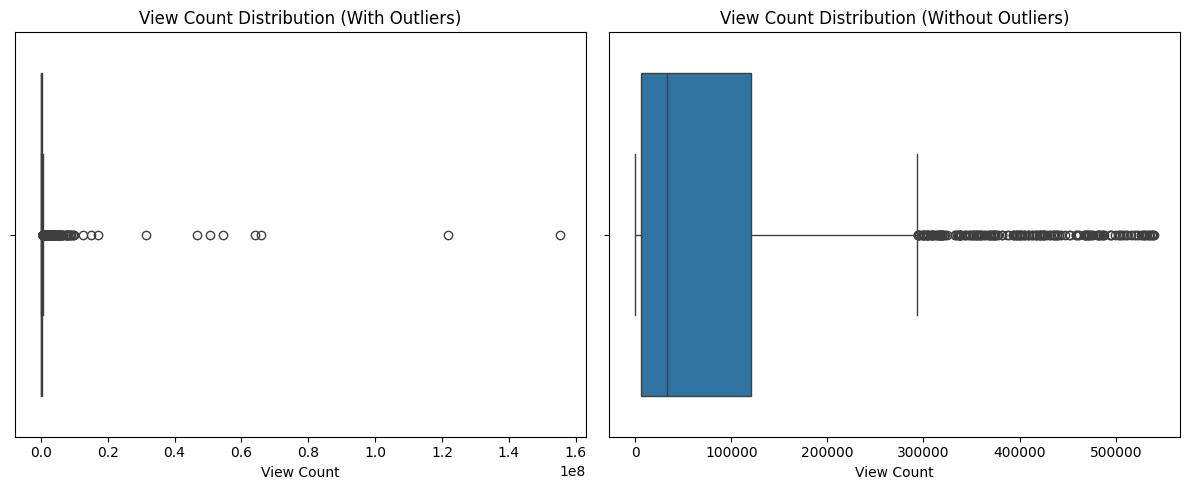

ANOVA F-statistic: 3.7188
p-value: 2.4946e-04
RESULT: There are statistically significant differences in View Count between color Clusters (p < 0.05).
This suggests that the view counts differ significantly across clusters.


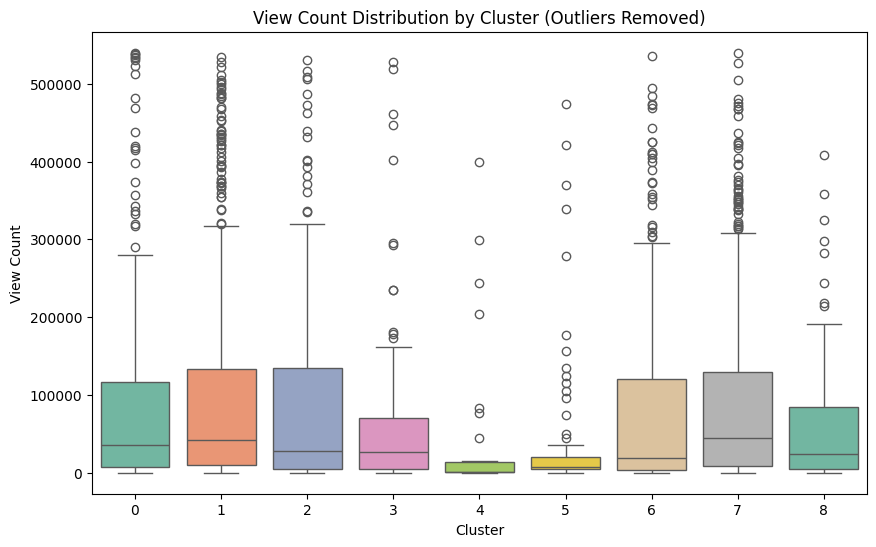

In [3]:
# --- Assume merged_data is already prepared as in your previous code ---

# 1. Remove outliers from View Count using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# 2. Show boxplots before and after outlier removal
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=merged_data['View Count'])
plt.title('View Count Distribution (With Outliers)')
plt.xlabel('View Count')

# Remove outliers
filtered_data = remove_outliers_iqr(merged_data, 'View Count')

plt.subplot(1, 2, 2)
sns.boxplot(x=filtered_data['View Count'])
plt.title('View Count Distribution (Without Outliers)')
plt.xlabel('View Count')

plt.tight_layout()
plt.show()

# 3. ANOVA: Test if View Count differs by Cluster
anova_result = stats.f_oneway(
    *[filtered_data[filtered_data['Cluster'] == c]['View Count'] for c in sorted(filtered_data['Cluster'].unique())]
)
f_stat = anova_result.statistic
p_value = anova_result.pvalue

print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4e}")

if p_value < 0.05:
    print("RESULT: There are statistically significant differences in View Count between color Clusters (p < 0.05).")
    print("This suggests that the view counts differ significantly across clusters.")
else:
    print("RESULT: There are no statistically significant differences in View Count between color Clusters (p >= 0.05).")

# 4. Boxplot: View Count distribution by Cluster (after outlier removal)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='View Count', data=filtered_data, palette='Set2')
plt.title('View Count Distribution by Cluster (Outliers Removed)')
plt.xlabel('Cluster')
plt.ylabel('View Count')
plt.show()

Like Correlation (No Weight)

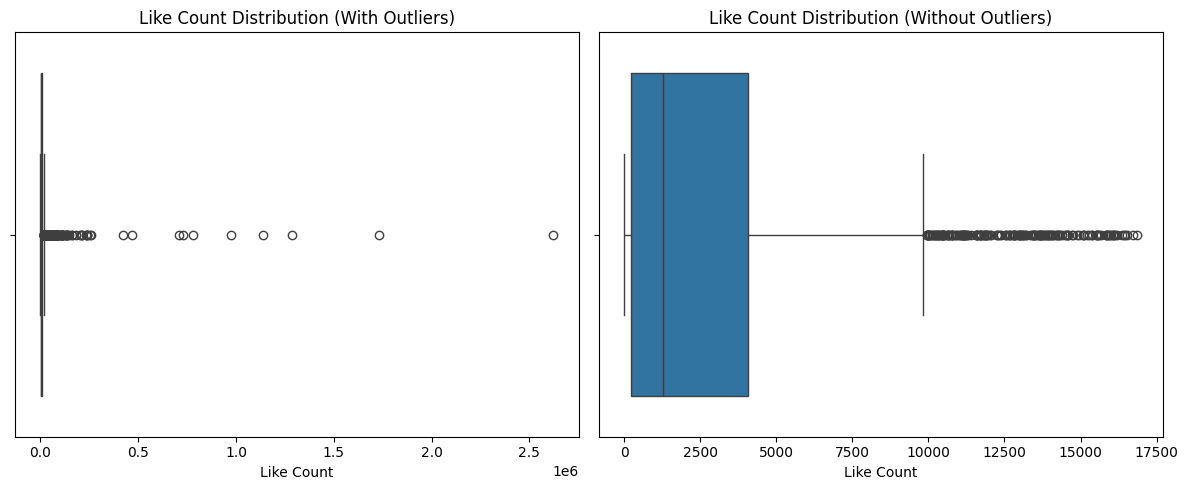

ANOVA F-statistic: 3.2958
p-value: 9.5238e-04
RESULT: There are statistically significant differences in Like Count between color Clusters (p < 0.05).
This suggests that the like counts differ significantly across clusters.


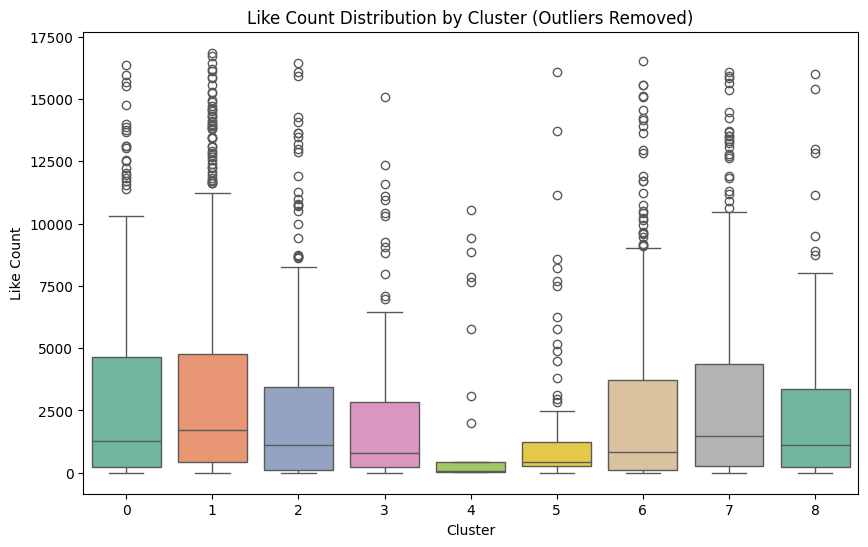

In [4]:

# 1. Remove outliers from Like Count using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# 2. Show boxplots before and after outlier removal
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=merged_data['Like Count'])
plt.title('Like Count Distribution (With Outliers)')
plt.xlabel('Like Count')

# Remove outliers
filtered_data = remove_outliers_iqr(merged_data, 'Like Count')

plt.subplot(1, 2, 2)
sns.boxplot(x=filtered_data['Like Count'])
plt.title('Like Count Distribution (Without Outliers)')
plt.xlabel('Like Count')

plt.tight_layout()
plt.show()

# 3. ANOVA: Test if Like Count differs by Cluster
anova_result = stats.f_oneway(
    *[filtered_data[filtered_data['Cluster'] == c]['Like Count'] for c in sorted(filtered_data['Cluster'].unique())]
)
f_stat = anova_result.statistic
p_value = anova_result.pvalue

print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4e}")

if p_value < 0.05:
    print("RESULT: There are statistically significant differences in Like Count between color Clusters (p < 0.05).")
    print("This suggests that the like counts differ significantly across clusters.")
else:
    print("RESULT: There are no statistically significant differences in Like Count between color Clusters (p >= 0.05).")

# 4. Boxplot: Like Count distribution by Cluster (after outlier removal)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Like Count', data=filtered_data, palette='Set2')
plt.title('Like Count Distribution by Cluster (Outliers Removed)')
plt.xlabel('Cluster')
plt.ylabel('Like Count')
plt.show()

Comment Correlation (No Weight)

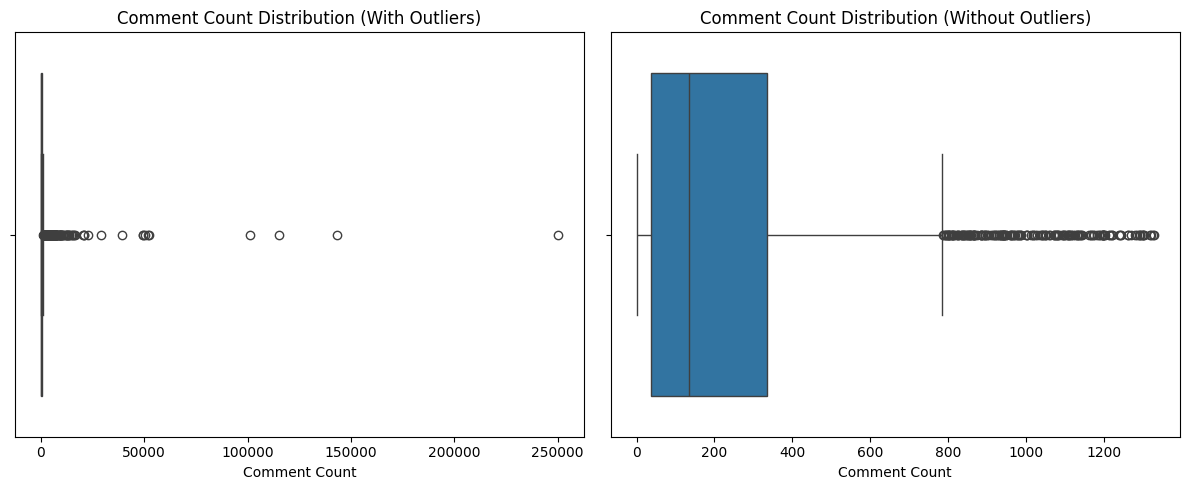

ANOVA F-statistic: 3.1132
p-value: 1.6800e-03
RESULT: There are statistically significant differences in Comment Count between color Clusters (p < 0.05).
This suggests that the comment counts differ significantly across clusters.


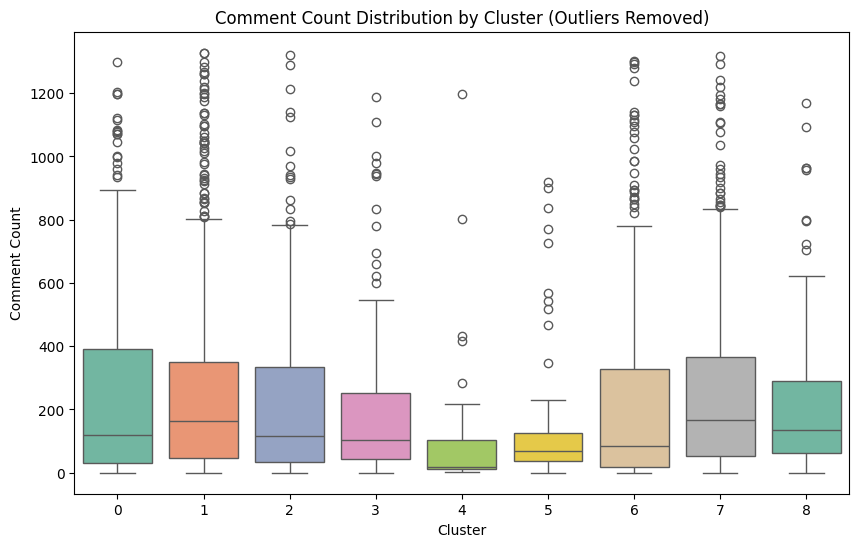

In [5]:
# 1. Remove outliers from Comment Count using the IQR method
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] >= lower) & (df[column] <= upper)]

# 2. Show boxplots before and after outlier removal
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=merged_data['Comment Count'])
plt.title('Comment Count Distribution (With Outliers)')
plt.xlabel('Comment Count')

# Remove outliers
filtered_data = remove_outliers_iqr(merged_data, 'Comment Count')

plt.subplot(1, 2, 2)
sns.boxplot(x=filtered_data['Comment Count'])
plt.title('Comment Count Distribution (Without Outliers)')
plt.xlabel('Comment Count')

plt.tight_layout()
plt.show()

# 3. ANOVA: Test if Comment Count differs by Cluster
anova_result = stats.f_oneway(
    *[filtered_data[filtered_data['Cluster'] == c]['Comment Count'] for c in sorted(filtered_data['Cluster'].unique())]
)
f_stat = anova_result.statistic
p_value = anova_result.pvalue

print(f"ANOVA F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4e}")

if p_value < 0.05:
    print("RESULT: There are statistically significant differences in Comment Count between color Clusters (p < 0.05).")
    print("This suggests that the comment counts differ significantly across clusters.")
else:
    print("RESULT: There are no statistically significant differences in Comment Count between color Clusters (p >= 0.05).")

# 4. Boxplot: Comment Count distribution by Cluster (after outlier removal)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='Comment Count', data=filtered_data, palette='Set2')
plt.title('Comment Count Distribution by Cluster (Outliers Removed)')
plt.xlabel('Cluster')
plt.ylabel('Comment Count')
plt.show()

## using 